# Predict ligand profiling using `kissim`

## Aim of this notebook

In order to asses the predictive power of `kissim`, we here choose a ligand-centric evaluation. We will compare if `kissim` can predict on- and off-targets determined in ligand profiling studies.

__Data__

- __Ligand-kinase profiling__: Karaman dataset downloaded from KinMap
- __Kinase-kinase profiling__: `kissim` dataset (kinase similarities)
- __Kinase names__: KinMap kinase names (maps kinase synonyms to main kinase names used in KinMap)
- __Ligand names__: PKIDB ligand names (maps ligand synonyms to main ligand names defined in PKIDB)

__Method__

- Prepare datasets
  - PDKIDB dataset: Ligand names
  - KinMap dataset: Kinase names
  - Karaman dataset: Ligand-kinase profiling data downloaded from KinMap (keep only ligands whose name can be cast to PKIDB name)
  - `kissim` dataset: Kinase-kinase profiling data (keep only kinases whose name can be cast to KinMap name)
  - Define ligands' on-targets as listed in PKIDB (keep only on-targets whose name can be cast to KinMap name)
- Merge datasets into "ligand dataset" per ligand; keep "ligand dataset" if enough coverage
  - "Ligand dataset" consists of
    - Ligand profiling data (Karaman et al. activities for ligand)
    - Kinase similarity data (`kissim` distances for ligand's on-target)
  - Coverage of a "ligand dataset" is high enough if the number of targets that fullfil the following conditions is greater than `MIN_N_TARGETS`:
    - Target is active w.r.t. to the ligand (in Karaman dataset; `KD_CUTOFF` defines activity)
    - Target is structurally covered in `kissim`
  - Some ligands have multiple on-targets; set up "ligand dataset" per ligand/on-target pair each
- Calculate `kissim` performance; measured using an enrichment factor within the top x% of ranked `kissim` results ($EF{_x\%}$)
  - Kinase is defined as active if Karaman et. al profiling data reports $K_d$ <= `KD_CUTOFF`
  - $EF{_x\%}$ is the ratio between _observed_ active kinases and the _theoretical maximum_ of active kinases in the top x% of ranked `kissim` results

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from IPython.display import display, HTML, Markdown
from rdkit.Chem import PandasTools

from kissim.comparison import FingerprintDistanceGenerator

In [2]:
plt.style.use("seaborn")

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data"
RESULTS = HERE / "../../results"

In [4]:
KD_CUTOFF = 100
MIN_N_TARGETS = 3

## Prepare datasets

We want to compare on- and off-targets seen in (1) the Karaman kinase-ligand profiling dataset and (2) the `kissim` kinase-kinase profiling dataset. Kinase names and ligand names must be homogenized; we will use kinase names from KinMap and ligand names from the PKIDB.

### PKIDB dataset: Ligand names

In [5]:
pkidb_path = DATA / "external/PKIDB/pkidb_2021-04-19.sdf"

,BrandName,Applicants,CHEMBL_ID,Canonical_Smiles,Chirality,First_Approval,Phase,SC_Patent,Synonyms,Withdrawn,...,NRB,TPSA,LogP,RoF,Melting point,Targets,Kinase families,FDA_approved,ID,ROMol
189,Tarceva,Osi Pharmaceuticals,CHEMBL553,COCCOc1cc2c(cc1OCCOC)ncnc2Nc3cccc(c3)C#C,Achiral Molecule,2004,4.0,US-6900221-B1,"[CP-358,774, CP-358774, CP-35877401, ERLOTINIB...",|Study NCT01006096 in United States was Withdr...,...,10.0,74.7,3.4,0.0,,"[EGFR, NR1I2]",Tyr<br>(*),Y,Erlotinib,
190,Balversa,Janssen,CHEMBL3545376,CC(C)NCCN(c1ccc2c(c1)nc(cn2)c3cnn(c3)C)c4cc(cc...,Achiral Molecule,2019,4.0,US-8895601-B2,"[BALVERSA, ERDAFITINIB, JNJ-42756493]",,...,9.0,77.3,4.2,0.0,,[FGFR1],Tyr,Y,Erdafitinib,
191,Rozlytrek,Ignyta,CHEMBL1983268,CN1CCN(CC1)c2ccc(c(c2)NC3CCOCC3)C(=O)Nc4c5cc(c...,Achiral Molecule,2019,4.0,US-8299057-B2,"[ENTRECTINIB, NMS-E628, ROZLYTREK, RXDX-101]",,...,7.0,85.5,5.0,2.0,,"[NTRK1, NTRK2, NTRK3, ROS1, ALK]",Tyr,Y,Entrectinib,
192,Braftovi,Novartis,CHEMBL3301612,C[C@@H](CNc1nccc(n1)c2cn(nc2c3cc(cc(c3F)NS(=O)...,Single Stereoisomer,2018,4.0,US-8501758-B2,"[BRAFTOVI, ENCORAFENIB, LGX-818, NVP-LGX-818-N...",,...,9.0,140.1,3.9,1.0,,[BRAF],TKL,Y,Encorafenib,
193,Copiktra,Infinity Pharmacueticals,CHEMBL3039502,C[C@@H](c1cc2cccc(c2c(=O)n1c3ccccc3)Cl)Nc4c5c(...,Single Stereoisomer,2018,4.0,US-8193182-B2,"[COPIKTRA, DUVELISIB, INK-1147, INK-1197, IPI-...",|Study NCT03370185 in United States was Withdr...,...,4.0,88.5,4.5,0.0,>190 ºC,"[PIK3CD, PIK3CG]",Atypical,Y,Duvelisib,

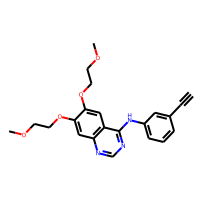
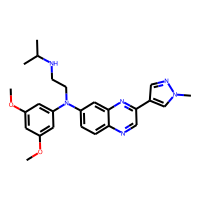
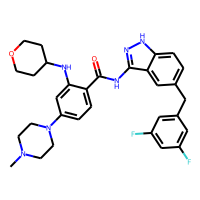
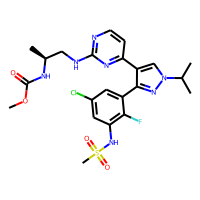
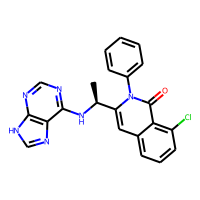

In [6]:
pkidb_df = PandasTools.LoadSDF(str(pkidb_path))
# Fix some columns that we will need later
pkidb_df["Synonyms"] = [i.split(" | ") for i in pkidb_df["Synonyms"].to_list()]
pkidb_df["Targets"] = [i.split("; ") for i in pkidb_df["Targets"]]
# Filter for FDA-approved drugs
pkidb_df = pkidb_df[pkidb_df["FDA_approved"] == "Y"]
pkidb_df.head()

### KinMap dataset: Kinase names

In [7]:
kinmap_url = "https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.csv"

In [8]:
kinmap_df = pd.read_csv(kinmap_url)
kinmap_df.head()

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519
1,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,NaN,Q07912
2,ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037
3,ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705
4,ADCK4,ADCK4,ADCK4,Uncharacterized aarF domain-containing protein...,Atypical,ABC1,ABC1-A,Q96D53


### Karaman dataset: Kinase-ligand profiling data

__Note__: Filters out ligands whose names cannot be mapped onto PKIDB ligand names.

In [9]:
karaman_path = DATA / "external/kinase_profiling_data/Karaman/Karaman_profiling.js"

#### Load data

In [10]:
with open(karaman_path, "r") as f:
    json_string = f.read()
json_string_cleaned = json_string.replace("=", ": ").replace(";", ", ").replace("\n", "")
json_string_cleaned = json_string_cleaned.replace("karaman_compounds", "\"karaman_compounds\"")
json_string_cleaned = json_string_cleaned.replace("karaman_profiling", "\"karaman_profiling\"")
json_string_cleaned = json_string_cleaned[:-3] + "}"
karaman_dict = json.loads(json_string_cleaned)

karaman_df = {}
for ligand, measures in karaman_dict["karaman_profiling"].items():
    karaman_df[ligand] = {measure["xName"]: measure["Kd(nM)"] for measure in measures}
karaman_df = pd.DataFrame(karaman_df)
print(karaman_df.shape)
karaman_df.head()

(268, 30)


,Staurosporine,JNJ-7706621,MLN-8054,PKC-412,SU-14813,SB-202190,CP-724714,VX-680/MK-0457,Dasatinib,Roscovitine/CYC-202,...,ZD-6474,Sunitinib,Flavopiridol,Erlotinib,MLN-518,LY-333531,CI-1033,EKB-569,PI-103,PTK-787
AAK1,1.2,200.0,NaN,48.0,66.0,NaN,NaN,290.0,NaN,NaN,...,NaN,11.0,5300.0,1200.0,NaN,900.0,NaN,3500.0,NaN,NaN
ABL1,290.0,1200.0,820.0,NaN,1500.0,NaN,NaN,13.0,0.53,NaN,...,270.0,830.0,NaN,310.0,NaN,NaN,1400.0,560.0,NaN,NaN
ABL2,110.0,NaN,3300.0,NaN,NaN,NaN,NaN,4.0,0.17,NaN,...,69.0,1000.0,NaN,200.0,NaN,NaN,870.0,370.0,NaN,NaN
ALK2,470.0,5900.0,NaN,NaN,NaN,NaN,NaN,1900.0,620.00,NaN,...,150.0,NaN,1900.0,NaN,2500.0,NaN,1700.0,NaN,NaN,NaN
ALK4,680.0,NaN,NaN,NaN,NaN,950.0,NaN,NaN,330.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
karaman_kinase_ids = karaman_df.index.to_list()

#### Cast KinMap to PKIDB ligand names

In [12]:
def get_pkidb_ligand_name(ligand_name, pkidb_df):
    if pkidb_df["ID"].isin([ligand_name]).any():
        return ligand_name
    else:
        ligand_name_pkidb = pkidb_df[pkidb_df["Synonyms"].apply(lambda x: ligand_name in x)]
        #print(ligand_name_pkidb)
        if len(ligand_name_pkidb) == 0:
            print(f"Not in PKIDB: {ligand_name}")
            return "unknown"
        elif len(ligand_name_pkidb) == 1:
            ligand_name_new = ligand_name_pkidb.squeeze()["ID"]
            print(f"Change {ligand_name} to {ligand_name_new}")
            return ligand_name_new
        else:
            print(f"Ambiguous ligand name: {ligand_name}")
            return "unknown"

In [13]:
ligand_names_new = [get_pkidb_ligand_name(i, pkidb_df) for i in karaman_df.columns]

Not in PKIDB: Staurosporine
Not in PKIDB: JNJ-7706621
Not in PKIDB: MLN-8054
Change PKC-412 to Midostaurin
Not in PKIDB: SU-14813
Not in PKIDB: SB-202190
Not in PKIDB: CP-724714
Not in PKIDB: VX-680/MK-0457
Not in PKIDB: Roscovitine/CYC-202
Not in PKIDB: SB-203580
Change CP-690550 to Tofacitinib
Not in PKIDB: GW-2580
Not in PKIDB: GW-786034
Not in PKIDB: VX-745
Not in PKIDB: SB-431542
Change ZD-6474 to Vandetanib
Not in PKIDB: Flavopiridol
Not in PKIDB: MLN-518
Not in PKIDB: LY-333531
Not in PKIDB: CI-1033
Not in PKIDB: EKB-569
Not in PKIDB: PI-103
Not in PKIDB: PTK-787


In [14]:
karaman_df.columns = ligand_names_new
karaman_df = karaman_df.drop("unknown", axis=1)
karaman_df

,Midostaurin,Dasatinib,Gefitinib,Tofacitinib,Imatinib,Lapatinib,Sorafenib,Vandetanib,Sunitinib,Erlotinib
AAK1,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1200.0
ABL1,NaN,0.53,NaN,NaN,12.0,NaN,680.0,270.0,830.0,310.0
ABL2,NaN,0.17,NaN,NaN,10.0,NaN,2900.0,69.0,1000.0,200.0
ALK2,NaN,620.00,NaN,NaN,NaN,NaN,NaN,150.0,NaN,NaN
ALK4,NaN,330.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
p38b,NaN,410.00,NaN,NaN,NaN,NaN,230.0,NaN,NaN,NaN
RAF1,NaN,570.00,NaN,NaN,1700.0,NaN,NaN,NaN,NaN,NaN
TGFbR2,NaN,2900.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ErbB2,NaN,1400.00,3500.0,NaN,NaN,7.0,NaN,2600.0,NaN,NaN


#### Number of measures per ligand

There are a few ligands with only very few measurements; exclude those.

In [15]:
karaman_df.notna().sum()

Midostaurin     96
Dasatinib       84
Gefitinib       33
Tofacitinib      7
Imatinib        27
Lapatinib        5
Sorafenib       46
Vandetanib      82
Sunitinib      163
Erlotinib       48
dtype: int64

Later, we will filter ligand dataset by number of targets that have (a) a bioactivity value w.r.t. to the ligand and (b) are structurally covered in `kissim`. If one of both conditions is violated the ligand dataset cannot be used for our evaluation.

### `kissim` dataset: Kinase-kinase profiling data

__Note__: Filters out kinases whose names cannot be mapped to KinMap kinase names.

In [16]:
distances_path = RESULTS / "../results/20210324/fingerprint_distances_41-41-41-41-41-41-41-41-83-83-83-83-111-111-111.json"

#### Load data

In [17]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_json(distances_path)

In [18]:
kissim_df = fingerprint_distance_generator.kinase_distance_matrix()
kissim_df

kinase2,AAK1,ABL1,ABL2,ACK,ACTR2,ACTR2B,ADCK3,AKT1,AKT2,ALK,...,ZAK,ZAP70,p110a,p110d,p110g,p38a,p38b,p38d,p38g,p70S6K
kinase1,,,,,,,,,,,,,,,,,,,,,
AAK1,0.000000,0.200719,0.211415,0.207997,0.227388,0.224240,0.253376,0.178940,0.207382,0.206200,...,0.248029,0.198185,0.302134,0.382581,0.379309,0.189047,0.216511,0.196086,0.220327,0.176171
ABL1,0.200719,0.000000,0.029331,0.099705,0.260727,0.243893,0.306453,0.177866,0.162627,0.095396,...,0.180444,0.150378,0.277927,0.350952,0.338871,0.155078,0.170590,0.175274,0.165569,0.156757
ABL2,0.211415,0.029331,0.000000,0.119626,0.282014,0.264120,0.318621,0.177867,0.171960,0.100184,...,0.201222,0.167463,0.297763,0.360277,0.352586,0.165517,0.181920,0.200965,0.188780,0.179851
ACK,0.207997,0.099705,0.119626,0.000000,0.281799,0.264738,0.314203,0.182938,0.155316,0.118632,...,0.175347,0.131905,0.284891,0.343387,0.343637,0.154222,0.175537,0.182760,0.167408,0.169289
ACTR2,0.227388,0.260727,0.282014,0.281799,0.000000,0.055600,0.300401,0.275968,0.302882,0.271331,...,0.298109,0.293067,0.394885,0.464096,0.455100,0.281995,0.300552,0.285048,0.295386,0.286531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p38a,0.189047,0.155078,0.165517,0.154222,0.281995,0.276624,0.247844,0.179611,0.161213,0.158609,...,0.225111,0.168059,0.262696,0.284657,0.273040,0.000000,0.066614,0.077543,0.091715,0.147344
p38b,0.216511,0.170590,0.181920,0.175537,0.300552,0.297521,0.327257,0.207468,0.182432,0.171898,...,0.218117,0.190999,0.282803,0.346517,0.337871,0.066614,0.000000,0.115847,0.100795,0.166337
p38d,0.196086,0.175274,0.200965,0.182760,0.285048,0.284825,0.308887,0.181697,0.171659,0.188743,...,0.244843,0.162702,0.268782,0.364471,0.360980,0.077543,0.115847,0.000000,0.108727,0.154980


#### Cast KLIFS to KinMap kinase names

In [19]:
def get_kinmap_kinase_name(kinase_name, kinmap_df):
    kinase_name = kinase_name.replace("-", "_")
    if kinmap_df["xName"].isin([kinase_name]).any():
        return kinase_name
    else:
        kinase_name_kinmap = kinmap_df[
            (kinmap_df["Manning\xa0Name"] == kinase_name) | (kinmap_df["HGNC\xa0Name"] == kinase_name)
        ]
        if len(kinase_name_kinmap) == 0:
            print(f"Not in KinMap: {kinase_name}")
            return "unknown"
        elif len(kinase_name_kinmap) == 1:
            kinase_name_new = kinase_name_kinmap.squeeze()["xName"]
            print(f"Change {kinase_name} to {kinase_name_new}")
            return kinase_name_new
        else:
            print(f"Ambiguous kinase name: {kinase_name}")
            return "unknown"

In [20]:
# Get KinMap kinase names
kinase_names_new = [get_kinmap_kinase_name(i, kinmap_df) for i in kissim_df.index]
# Rename kinases
kissim_df.index = kinase_names_new
kissim_df.columns = kinase_names_new
print(f"Before correction: {kissim_df.shape}")
# Remove kinases that could not be mapped to KinMap
kissim_df = kissim_df.drop("unknown", axis=0).drop("unknown", axis=1)
print(f"After correction:  {kissim_df.shape}")

Change DCLK1 to DCAMKL1
Not in KinMap: PI4K2A
Not in KinMap: PI4K2B
Not in KinMap: PI4KB
Not in KinMap: PIK3C3
Not in KinMap: p110a
Not in KinMap: p110d
Not in KinMap: p110g
Before correction: (293, 293)
After correction:  (286, 286)


### Define ligands' on-targets (PKIDB dataset)

__Note__: Filters out ligands whose targets are not available in PKIDB.

In [21]:
def ligand_to_pkidb_targets(pkidb_df, ligand_name):
    
    targets = pkidb_df[pkidb_df["ID"] == ligand_name]["Targets"]
    if len(targets) == 1:
        return targets.reset_index(drop=True)[0]
    elif len(targets) > 1:
        print(f"Ambiguous ligand name: {ligand_name}")
    else:
        print(f"Not in PKIDB: {ligand_name}")

In [22]:
ligand_targets = [[ligand_name, ligand_to_pkidb_targets(pkidb_df, ligand_name)] for ligand_name in karaman_df.columns]
ligand_targets = pd.DataFrame(ligand_targets, columns=["ligand", "targets_pkidb"])
ligand_targets = ligand_targets.explode("targets_pkidb", ignore_index=True)
# Remove ligands without target information
ligand_targets = ligand_targets[ligand_targets["targets_pkidb"] != "nan"]
# Cast PKIDB to KinMap kinase names
ligand_targets["targets_kinmap"] = ligand_targets["targets_pkidb"].apply(lambda x: get_kinmap_kinase_name(x, kinmap_df))
ligand_targets["targets_kinmap"] = ligand_targets["targets_kinmap"].replace("unknown", "-")
ligand_targets.head()

Change EPHA2 to EphA2
Change YES1 to YES
Change PDGFRB to PDGFRb
Change NTRK1 to TRKA
Change CSF1R to FMS
Change PDGFRA to PDGFRa
Change PDGFRB to PDGFRb
Change ERBB2 to ErbB2
Change PDGFRB to PDGFRb
Not in KinMap: VEGFA
Change PTK6 to BRK
Change TEK to TIE2
Change PDGFRB to PDGFRb
Change CSF1R to FMS
Change PDGFRA to PDGFRa
Not in KinMap: NR1I2


,ligand,targets_pkidb,targets_kinmap
1,Dasatinib,ABL1,ABL1
2,Dasatinib,SRC,SRC
3,Dasatinib,EPHA2,EphA2
4,Dasatinib,LCK,LCK
5,Dasatinib,YES1,YES


In [23]:
pd.set_option("max_colwidth", 100)

a = ligand_targets.groupby("ligand")["targets_pkidb"].apply(list)
b = ligand_targets[ligand_targets["targets_kinmap"] != "-"].groupby("ligand")["targets_kinmap"].apply(list)
ligand_targets_imploded = pd.concat([a, b], axis=1)
ligand_targets_imploded = ligand_targets_imploded.loc[ligand_targets_imploded["targets_kinmap"].apply(len).sort_values().index, :].reset_index()
ligand_targets_imploded["main_target_kinmap"] = ligand_targets_imploded["targets_kinmap"].apply(lambda x: x[0])
ligand_targets_imploded

,ligand,targets_pkidb,targets_kinmap,main_target_kinmap
0,Erlotinib,"[EGFR, NR1I2]",[EGFR],EGFR
1,Gefitinib,[EGFR],[EGFR],EGFR
2,Lapatinib,"[EGFR, ERBB2]","[EGFR, ErbB2]",EGFR
3,Tofacitinib,"[JAK1, JAK2, JAK3, TYK2]","[JAK1, JAK2, JAK3, TYK2]",JAK1
4,Vandetanib,"[VEGFA, EGFR, PTK6, TEK, RET]","[EGFR, BRK, TIE2, RET]",EGFR
5,Imatinib,"[KIT, RET, NTRK1, CSF1R, PDGFRA, DDR1, ABL1, PDGFRB]","[KIT, RET, TRKA, FMS, PDGFRa, DDR1, ABL1, PDGFRb]",KIT
6,Sunitinib,"[PDGFRB, FLT1, KIT, KDR, FLT4, FLT3, CSF1R, PDGFRA]","[PDGFRb, FLT1, KIT, KDR, FLT4, FLT3, FMS, PDGFRa]",PDGFRb
7,Dasatinib,"[ABL1, SRC, EPHA2, LCK, YES1, KIT, PDGFRB, ABL2, FYN]","[ABL1, SRC, EphA2, LCK, YES, KIT, PDGFRb, ABL2, FYN]",ABL1
8,Sorafenib,"[BRAF, RAF1, FLT4, KDR, FLT3, PDGFRB, KIT, FGFR1, RET, FLT1]","[BRAF, RAF1, FLT4, KDR, FLT3, PDGFRb, KIT, FGFR1, RET, FLT1]",BRAF


Ligand targets listed in the DrugBank or PKIDB are including reported on- and off-targets. For the purpose of this notebook, we would like to identify the intended targets (on-targets) only. This seems to be a not-so-easy task and involves a manual assignment based on literature search.

We will assign main on-targets manually based on the following table including
- Main on-targets reported in literature
- Availability of profiling data (with <= 100nM activity) for a given ligand-kinase combo in the Karaman profiling dataset 
- Use KinMap kinase names (since we are using the Karaman dataset provided by KinMap)
- For multitargeted ligands define multiple targets

| Approved kinase inhibitor                            | Intended kinase target (\* in Karaman profiling dataset <= 100nM) |
|------------------------------------------------------|---------------------------------------------------------|
| [Erlotinib](https://go.drugbank.com/drugs/DB00530)   | EGFR\* |
| [Gefitinib](https://go.drugbank.com/drugs/DB00317)   | EGFR\* |
| [Lapatinib](https://go.drugbank.com/drugs/DB01259)   | EGFR\*, ERBB2\* |
| [Tofacitinib](https://go.drugbank.com/drugs/DB08895) | JAK1, JAK2, JAK3 |
| [Vandetanib](https://go.drugbank.com/drugs/DB05294)  | VEGFR2, EGFR, RET; [see paper](https://www.ema.europa.eu/en/documents/assessment-report/caprelsa-epar-public-assessment-report_en.pdf) |
| [Imatinib](https://go.drugbank.com/drugs/DB00619)    | multitargeted inhibitor - TK: ABL1\*, KIT\*, PDGFRa\*; [see paper](https://www.hindawi.com/journals/cherp/2014/357027/) |
| [Sunitinib](https://go.drugbank.com/drugs/DB01268)   | multitargeted inhibitor - TK: VEGFR1/2, PDFGRa/b, KIT, FLT2, RET, CSF1R; [see paper](https://link.springer.com/article/10.2165/11318860-000000000-00000) |
| [Dasatinib](https://go.drugbank.com/drugs/DB01254)   | multitargeted inhibitor - TK: ABL1 (BCRABL), SRC, Eph\_ (Ephrins), \_GFR (GFR); see DrugBank Identification > Description |
| [Sorafenib](https://go.drugbank.com/drugs/DB00398)   | multitargeted inhibitor - TK/TKL (Raf/Mek/Erk pathways): RAF\_ (Raf) \[TKL\], PDFGR\_ (PDFG), VEGF2/3, KIT; see DrugBank Identification > Description |

Manual ligand-kinase list:

In [24]:
ligand_targets_list = [
    ["Erlotinib", "EGFR"],
    ["Gefitinib", "EGFR"],
    ["Lapatinib", "EGFR"],
    ["Lapatinib", "ErbB2"],
    ["Tofacitinib", "JAK1"],
    ["Vandetanib", "EGFR"],
    ["Imatinib", "ABL1"],
    ["Sunitinib", "KIT"],
    ["Dasatinib", "ABL1"],
    ["Sorafenib", "BRAF"]
]

Full ligand-kinase list:

In [25]:
ligand_targets_list = ligand_targets[ligand_targets["targets_kinmap"] != "-"][["ligand", "targets_kinmap"]]
ligand_targets_list = ligand_targets_list.to_numpy().tolist()
len(ligand_targets_list)

47

## Merge datasets into "ligand datasets"

We will merge now profiling (Karaman et al.) and kinase similarity (`kissim`) information into one dataset per ligand (ligand dataset). 

We will only keep ligand datasets if we like the coverage of active kinases covered by `kissim` (Karaman et al.)

In [26]:
def kissim_distance_by_kinase_name(kissim_df, kinase_name_on_target, kinase_name_query):
    try:
        kissim_distance = kissim_df[kinase_name_on_target][kinase_name_query]
    except KeyError:
        kissim_distance = None
    return kissim_distance

In [27]:
def create_ligand_dataset(karaman_df, kissim_df, ligand_name, kinase_name, kd_cutoff):
    
    ligand_dataset = pd.DataFrame(
        {
            "kinase.kinmap_name": karaman_df[ligand_name].index.to_list(),
            "activity.kd_nm": karaman_df[ligand_name].to_list()
        }
    )
    # Sort by Kd and set activity rank accordingly
    #ligand_dataset = ligand_dataset.sort_values(by="activity.kd_nm").reset_index(drop=True)
    #ligand_dataset["activity.rank"] = ligand_dataset.index + 1
    ligand_dataset["activity.rank"] = ligand_dataset["activity.kd_nm"].rank()
    # Define active kinases
    ligand_dataset["activity.active"] = ligand_dataset["activity.kd_nm"] <= kd_cutoff
    # Add kissim data
    ligand_dataset["kissim.distance"] = [
        kissim_distance_by_kinase_name(kissim_df, kinase_name, kinase_name_query) for kinase_name_query in ligand_dataset["kinase.kinmap_name"]
    ]
    ligand_dataset["kissim.rank"] = ligand_dataset["kissim.distance"].rank()
    
    return ligand_dataset

### Example ligand dataset

In [28]:
example_ligand_dataset = create_ligand_dataset(karaman_df, kissim_df, "Erlotinib", "EGFR", KD_CUTOFF)
example_ligand_dataset

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
0,AAK1,1200.0,26.0,False,0.217373,172.0
1,ABL1,310.0,9.0,False,0.102957,7.0
2,ABL2,200.0,6.0,False,0.114404,16.0
3,ALK2,NaN,NaN,False,0.216092,171.0
4,ALK4,NaN,NaN,False,NaN,NaN
...,...,...,...,...,...,...
263,p38b,NaN,NaN,False,0.179963,145.0
264,RAF1,NaN,NaN,False,0.212681,169.0
265,TGFbR2,NaN,NaN,False,0.324387,185.0
266,ErbB2,NaN,NaN,False,0.100450,5.0


Now, before we can use this ligand dataset for anything, we need to decide if it is good enough to be used for an analysis. What is good enough?
Use a ligand dataset only if the number of targets that fullfil the following conditions is greater than `MIN_N_TARGETS`:

- target is active w.r.t. to the ligand (in Karaman dataset; `KD_CUTOFF` defines activity)
- target is structurally covered in `kissim`

In [29]:
example_ligand_dataset[
    (example_ligand_dataset["activity.active"]) & (example_ligand_dataset["kissim.distance"].notna())
]

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
70,EGFR,0.67,1.0,True,0.000000,1.0
98,GAK,3.10,2.0,True,0.212938,170.0
117,LOK,19.00,3.0,True,0.109966,14.0
208,SLK,26.00,4.0,True,0.123032,34.0


### Select ligand datasets with enough coverage

Iterate over all proposed ligand-target pairs and keep only those that meet the conditions described above.

In [30]:
ligand_targets_list_selected = []

for ligand_name, kinase_name in ligand_targets_list:
    display(Markdown(f"#### {ligand_name} / {kinase_name}"))
    example_ligand_dataset = create_ligand_dataset(karaman_df, kissim_df, ligand_name, kinase_name, KD_CUTOFF)
    a = example_ligand_dataset[
        (example_ligand_dataset["activity.active"]) & (example_ligand_dataset["kissim.distance"].notna())
    ]
    if a.shape[0] > MIN_N_TARGETS:
        display(Markdown("Include ligand dataset: YES"))
        ligand_targets_list_selected.append([ligand_name, kinase_name])
    else:
        display(Markdown("Include ligand dataset: NO"))
    display(HTML(a.to_html()))

#### Dasatinib / ABL1

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,0.530,16.0,True,0.000000,1.0
2,ABL2,0.170,2.0,True,0.029331,2.0
21,BMX,1.400,26.5,True,0.116837,31.0
24,BTK,1.400,26.5,True,0.093853,4.0
48,FMS,0.580,18.0,True,0.128358,39.0
49,CSK,1.000,24.0,True,0.116246,29.0
62,DDR1,0.690,21.0,True,0.112946,27.0
63,DDR2,3.200,30.0,True,0.140192,57.0
72,EphA2,0.850,23.0,True,0.111622,24.0
73,EphA3,0.093,1.0,True,0.112463,25.0


#### Dasatinib / SRC

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,0.530,16.0,True,0.099830,7.0
2,ABL2,0.170,2.0,True,0.124612,27.0
21,BMX,1.400,26.5,True,0.145992,70.0
24,BTK,1.400,26.5,True,0.101154,8.0
48,FMS,0.580,18.0,True,0.142169,57.0
49,CSK,1.000,24.0,True,0.129087,33.0
62,DDR1,0.690,21.0,True,0.125918,29.0
63,DDR2,3.200,30.0,True,0.153326,94.0
72,EphA2,0.850,23.0,True,0.111867,12.0
73,EphA3,0.093,1.0,True,0.113471,14.0


#### Dasatinib / EphA2

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,0.530,16.0,True,0.111622,22.0
2,ABL2,0.170,2.0,True,0.121355,31.0
21,BMX,1.400,26.5,True,0.145572,53.0
24,BTK,1.400,26.5,True,0.104043,16.0
48,FMS,0.580,18.0,True,0.130278,41.0
49,CSK,1.000,24.0,True,0.130559,42.0
62,DDR1,0.690,21.0,True,0.088097,8.0
63,DDR2,3.200,30.0,True,0.123989,35.0
72,EphA2,0.850,23.0,True,0.000000,1.0
73,EphA3,0.093,1.0,True,0.048217,2.0


#### Dasatinib / LCK

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,0.530,16.0,True,0.098329,6.0
2,ABL2,0.170,2.0,True,0.130490,35.0
21,BMX,1.400,26.5,True,0.144342,69.0
24,BTK,1.400,26.5,True,0.123438,22.0
48,FMS,0.580,18.0,True,0.133491,41.0
49,CSK,1.000,24.0,True,0.130358,34.0
62,DDR1,0.690,21.0,True,0.104021,8.0
63,DDR2,3.200,30.0,True,0.133586,42.0
72,EphA2,0.850,23.0,True,0.109958,13.0
73,EphA3,0.093,1.0,True,0.107936,11.0


#### Dasatinib / YES

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank


#### Dasatinib / KIT

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,0.530,16.0,True,0.124465,17.0
2,ABL2,0.170,2.0,True,0.159060,60.0
21,BMX,1.400,26.5,True,0.174217,98.0
24,BTK,1.400,26.5,True,0.139922,28.0
48,FMS,0.580,18.0,True,0.027952,2.0
49,CSK,1.000,24.0,True,0.155923,55.0
62,DDR1,0.690,21.0,True,0.104184,9.0
63,DDR2,3.200,30.0,True,0.140360,29.0
72,EphA2,0.850,23.0,True,0.132216,21.0
73,EphA3,0.093,1.0,True,0.131414,20.0


#### Dasatinib / PDGFRb

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,0.530,16.0,True,0.141659,16.0
2,ABL2,0.170,2.0,True,0.177543,84.0
21,BMX,1.400,26.5,True,0.174924,76.0
24,BTK,1.400,26.5,True,0.158018,41.0
48,FMS,0.580,18.0,True,0.066466,2.0
49,CSK,1.000,24.0,True,0.174187,74.0
62,DDR1,0.690,21.0,True,0.134360,13.0
63,DDR2,3.200,30.0,True,0.151402,30.0
72,EphA2,0.850,23.0,True,0.144058,18.0
73,EphA3,0.093,1.0,True,0.160116,49.0


#### Dasatinib / ABL2

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,0.530,16.0,True,0.029331,2.0
2,ABL2,0.170,2.0,True,0.000000,1.0
21,BMX,1.400,26.5,True,0.130782,25.0
24,BTK,1.400,26.5,True,0.104365,4.0
48,FMS,0.580,18.0,True,0.153349,51.0
49,CSK,1.000,24.0,True,0.112400,6.0
62,DDR1,0.690,21.0,True,0.113783,7.0
63,DDR2,3.200,30.0,True,0.145364,43.0
72,EphA2,0.850,23.0,True,0.121355,15.0
73,EphA3,0.093,1.0,True,0.120817,12.0


#### Dasatinib / FYN

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,0.530,16.0,True,0.102045,5.0
2,ABL2,0.170,2.0,True,0.132444,26.0
21,BMX,1.400,26.5,True,0.142718,43.0
24,BTK,1.400,26.5,True,0.127304,17.0
48,FMS,0.580,18.0,True,0.152228,80.0
49,CSK,1.000,24.0,True,0.147632,62.0
62,DDR1,0.690,21.0,True,0.131906,24.0
63,DDR2,3.200,30.0,True,0.160065,97.0
72,EphA2,0.850,23.0,True,0.129877,22.0
73,EphA3,0.093,1.0,True,0.128661,20.0


#### Gefitinib / EGFR

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
70,EGFR,1.0,1.0,True,0.000000,1.0
98,GAK,13.0,2.0,True,0.212938,170.0


#### Tofacitinib / JAK1

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank


#### Tofacitinib / JAK2

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank


#### Tofacitinib / JAK3

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank


#### Tofacitinib / TYK2

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank


#### Imatinib / KIT

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,12.0,3.0,True,0.124465,17.0
2,ABL2,10.0,2.0,True,0.159060,60.0
48,FMS,19.0,7.0,True,0.027952,2.0
62,DDR1,0.7,1.0,True,0.104184,9.0
63,DDR2,15.0,6.0,True,0.140360,29.0
110,KIT,14.0,4.5,True,0.000000,1.0
113,LCK,40.0,9.0,True,0.128003,18.0
172,PDGFRa,31.0,8.0,True,0.047585,3.0
173,PDGFRb,14.0,4.5,True,0.068724,7.0


#### Imatinib / RET

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,12.0,3.0,True,0.134425,33.0
2,ABL2,10.0,2.0,True,0.138442,37.0
48,FMS,19.0,7.0,True,0.127873,23.0
62,DDR1,0.7,1.0,True,0.143871,47.0
63,DDR2,15.0,6.0,True,0.183754,113.0
110,KIT,14.0,4.5,True,0.088441,3.0
113,LCK,40.0,9.0,True,0.131937,27.0
172,PDGFRa,31.0,8.0,True,0.147058,49.0
173,PDGFRb,14.0,4.5,True,0.148148,50.0


#### Imatinib / TRKA

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,12.0,3.0,True,0.131116,19.0
2,ABL2,10.0,2.0,True,0.130741,18.0
48,FMS,19.0,7.0,True,0.145751,41.0
62,DDR1,0.7,1.0,True,0.099175,4.0
63,DDR2,15.0,6.0,True,0.119945,9.0
110,KIT,14.0,4.5,True,0.145004,39.0
113,LCK,40.0,9.0,True,0.134572,25.0
172,PDGFRa,31.0,8.0,True,0.137355,28.0
173,PDGFRb,14.0,4.5,True,0.165082,75.0


#### Imatinib / FMS

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,12.0,3.0,True,0.128358,15.0
2,ABL2,10.0,2.0,True,0.153349,45.0
48,FMS,19.0,7.0,True,0.000000,1.0
62,DDR1,0.7,1.0,True,0.107901,10.0
63,DDR2,15.0,6.0,True,0.145014,33.0
110,KIT,14.0,4.5,True,0.027952,2.0
113,LCK,40.0,9.0,True,0.133491,19.0
172,PDGFRa,31.0,8.0,True,0.044048,3.0
173,PDGFRb,14.0,4.5,True,0.066466,6.0


#### Imatinib / PDGFRa

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,12.0,3.0,True,0.136874,19.0
2,ABL2,10.0,2.0,True,0.159210,53.0
48,FMS,19.0,7.0,True,0.044048,2.0
62,DDR1,0.7,1.0,True,0.106955,11.0
63,DDR2,15.0,6.0,True,0.139729,22.0
110,KIT,14.0,4.5,True,0.047585,3.0
113,LCK,40.0,9.0,True,0.130520,15.0
172,PDGFRa,31.0,8.0,True,0.000000,1.0
173,PDGFRb,14.0,4.5,True,0.083474,8.0


#### Imatinib / DDR1

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,12.0,3.0,True,0.112946,16.0
2,ABL2,10.0,2.0,True,0.113783,18.0
48,FMS,19.0,7.0,True,0.107901,12.0
62,DDR1,0.7,1.0,True,0.000000,1.0
63,DDR2,15.0,6.0,True,0.057503,2.0
110,KIT,14.0,4.5,True,0.104184,8.0
113,LCK,40.0,9.0,True,0.104021,7.0
172,PDGFRa,31.0,8.0,True,0.106955,10.0
173,PDGFRb,14.0,4.5,True,0.134360,46.0


#### Imatinib / ABL1

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,12.0,3.0,True,0.000000,1.0
2,ABL2,10.0,2.0,True,0.029331,2.0
48,FMS,19.0,7.0,True,0.128358,39.0
62,DDR1,0.7,1.0,True,0.112946,27.0
63,DDR2,15.0,6.0,True,0.140192,57.0
110,KIT,14.0,4.5,True,0.124465,38.0
113,LCK,40.0,9.0,True,0.098329,6.0
172,PDGFRa,31.0,8.0,True,0.136874,50.0
173,PDGFRb,14.0,4.5,True,0.141659,58.0


#### Imatinib / PDGFRb

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,12.0,3.0,True,0.141659,16.0
2,ABL2,10.0,2.0,True,0.177543,84.0
48,FMS,19.0,7.0,True,0.066466,2.0
62,DDR1,0.7,1.0,True,0.134360,13.0
63,DDR2,15.0,6.0,True,0.151402,30.0
110,KIT,14.0,4.5,True,0.068724,3.0
113,LCK,40.0,9.0,True,0.142652,17.0
172,PDGFRa,31.0,8.0,True,0.083474,4.0
173,PDGFRb,14.0,4.5,True,0.000000,1.0


#### Lapatinib / EGFR

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
70,EGFR,2.4,1.0,True,0.000000,1.0
81,ErbB4,54.0,3.0,True,0.051433,2.0
266,ErbB2,7.0,2.0,True,0.100450,5.0


#### Lapatinib / ErbB2

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
70,EGFR,2.4,1.0,True,0.100450,2.0
81,ErbB4,54.0,3.0,True,0.123138,3.0
266,ErbB2,7.0,2.0,True,0.000000,1.0


#### Sorafenib / BRAF

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,28.0,4.0,True,0.170301,108.0
62,DDR1,1.5,1.0,True,0.145975,28.0
63,DDR2,6.6,2.0,True,0.159968,72.0
93,FLT1,31.0,5.5,True,0.174541,118.0
94,FLT3,13.0,3.0,True,0.160880,77.0
110,KIT,31.0,5.5,True,0.155433,55.0


#### Sorafenib / RAF1

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,28.0,4.0,True,0.238384,111.0
62,DDR1,1.5,1.0,True,0.224595,81.0
63,DDR2,6.6,2.0,True,0.226566,87.0
93,FLT1,31.0,5.5,True,0.241711,121.0
94,FLT3,13.0,3.0,True,0.203326,20.0
110,KIT,31.0,5.5,True,0.235087,104.0


#### Sorafenib / FLT4

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank


#### Sorafenib / KDR

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,28.0,4.0,True,0.050987,3.0
62,DDR1,1.5,1.0,True,0.115366,14.0
63,DDR2,6.6,2.0,True,0.132471,30.0
93,FLT1,31.0,5.5,True,0.056072,4.0
94,FLT3,13.0,3.0,True,0.068701,6.0
110,KIT,31.0,5.5,True,0.049999,2.0


#### Sorafenib / FLT3

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,28.0,4.0,True,0.055734,2.0
62,DDR1,1.5,1.0,True,0.117390,11.0
63,DDR2,6.6,2.0,True,0.146427,38.0
93,FLT1,31.0,5.5,True,0.086015,6.0
94,FLT3,13.0,3.0,True,0.000000,1.0
110,KIT,31.0,5.5,True,0.058285,4.0


#### Sorafenib / PDGFRb

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,28.0,4.0,True,0.066466,2.0
62,DDR1,1.5,1.0,True,0.134360,13.0
63,DDR2,6.6,2.0,True,0.151402,30.0
93,FLT1,31.0,5.5,True,0.097365,7.0
94,FLT3,13.0,3.0,True,0.087506,5.0
110,KIT,31.0,5.5,True,0.068724,3.0


#### Sorafenib / KIT

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,28.0,4.0,True,0.027952,2.0
62,DDR1,1.5,1.0,True,0.104184,9.0
63,DDR2,6.6,2.0,True,0.140360,29.0
93,FLT1,31.0,5.5,True,0.064793,6.0
94,FLT3,13.0,3.0,True,0.058285,5.0
110,KIT,31.0,5.5,True,0.000000,1.0


#### Sorafenib / FGFR1

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,28.0,4.0,True,0.105572,10.0
62,DDR1,1.5,1.0,True,0.115427,16.0
63,DDR2,6.6,2.0,True,0.123649,23.0
93,FLT1,31.0,5.5,True,0.109623,12.0
94,FLT3,13.0,3.0,True,0.102850,9.0
110,KIT,31.0,5.5,True,0.106575,11.0


#### Sorafenib / RET

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,28.0,4.0,True,0.127873,23.0
62,DDR1,1.5,1.0,True,0.143871,47.0
63,DDR2,6.6,2.0,True,0.183754,113.0
93,FLT1,31.0,5.5,True,0.160235,78.0
94,FLT3,13.0,3.0,True,0.133893,31.0
110,KIT,31.0,5.5,True,0.088441,3.0


#### Sorafenib / FLT1

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,28.0,4.0,True,0.082432,5.0
62,DDR1,1.5,1.0,True,0.130493,10.0
63,DDR2,6.6,2.0,True,0.169988,41.0
93,FLT1,31.0,5.5,True,0.000000,1.0
94,FLT3,13.0,3.0,True,0.086015,6.0
110,KIT,31.0,5.5,True,0.064793,3.0


#### Vandetanib / EGFR

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
2,ABL2,69.0,8.0,True,0.114404,16.0
62,DDR1,11.0,3.0,True,0.131879,46.0
70,EGFR,9.5,2.0,True,0.000000,1.0
78,EphA8,91.0,13.0,True,0.134879,51.0
98,GAK,86.0,11.0,True,0.212938,170.0
113,LCK,17.0,4.0,True,0.112547,15.0
117,LOK,81.0,10.0,True,0.109966,14.0
173,PDGFRb,88.0,12.0,True,0.134548,50.0
202,RET,34.0,5.0,True,0.106536,9.0
205,RIPK2,4.6,1.0,True,0.170955,132.0


#### Vandetanib / BRK

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
2,ABL2,69.0,8.0,True,0.162004,27.0
62,DDR1,11.0,3.0,True,0.185645,72.0
70,EGFR,9.5,2.0,True,0.118364,6.0
78,EphA8,91.0,13.0,True,0.202325,119.0
98,GAK,86.0,11.0,True,0.240017,169.0
113,LCK,17.0,4.0,True,0.164441,33.0
117,LOK,81.0,10.0,True,0.170396,42.0
173,PDGFRb,88.0,12.0,True,0.179332,57.0
202,RET,34.0,5.0,True,0.200331,112.0
205,RIPK2,4.6,1.0,True,0.179804,59.0


#### Vandetanib / TIE2

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
2,ABL2,69.0,8.0,True,0.120891,6.0
62,DDR1,11.0,3.0,True,0.121175,7.0
70,EGFR,9.5,2.0,True,0.130202,15.0
78,EphA8,91.0,13.0,True,0.147677,44.0
98,GAK,86.0,11.0,True,0.225514,169.0
113,LCK,17.0,4.0,True,0.122087,8.0
117,LOK,81.0,10.0,True,0.139495,29.0
173,PDGFRb,88.0,12.0,True,0.145977,43.0
202,RET,34.0,5.0,True,0.149050,49.0
205,RIPK2,4.6,1.0,True,0.200221,141.0


#### Vandetanib / RET

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
2,ABL2,69.0,8.0,True,0.138442,37.0
62,DDR1,11.0,3.0,True,0.143871,47.0
70,EGFR,9.5,2.0,True,0.106536,8.0
78,EphA8,91.0,13.0,True,0.162123,83.0
98,GAK,86.0,11.0,True,0.219557,152.0
113,LCK,17.0,4.0,True,0.131937,27.0
117,LOK,81.0,10.0,True,0.151009,60.0
173,PDGFRb,88.0,12.0,True,0.148148,50.0
202,RET,34.0,5.0,True,0.000000,1.0
205,RIPK2,4.6,1.0,True,0.206031,141.0


#### Sunitinib / PDGFRb

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
0,AAK1,11.000,13.0,True,0.236579,164.0
10,AMPKa1,19.000,23.0,True,0.163160,51.0
11,AMPKa2,89.000,47.0,True,0.171835,70.0
17,AXL,9.000,12.0,True,0.190024,112.0
18,BIKE,5.500,9.5,True,0.249656,170.0
28,CaMK2a,80.000,44.0,True,0.179856,86.0
44,CLK1,22.000,27.5,True,0.184836,98.0
45,CLK2,20.000,25.5,True,0.186277,100.0
47,CLK4,29.000,31.0,True,0.182593,92.0
48,FMS,2.000,8.0,True,0.066466,2.0


#### Sunitinib / FLT1

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
0,AAK1,11.000,13.0,True,0.240203,161.0
10,AMPKa1,19.000,23.0,True,0.182453,67.0
11,AMPKa2,89.000,47.0,True,0.179266,59.0
17,AXL,9.000,12.0,True,0.214264,139.0
18,BIKE,5.500,9.5,True,0.249989,165.0
28,CaMK2a,80.000,44.0,True,0.183062,69.0
44,CLK1,22.000,27.5,True,0.201498,116.0
45,CLK2,20.000,25.5,True,0.209220,128.0
47,CLK4,29.000,31.0,True,0.202782,119.0
48,FMS,2.000,8.0,True,0.082432,5.0


#### Sunitinib / KIT

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
0,AAK1,11.000,13.0,True,0.222886,159.0
10,AMPKa1,19.000,23.0,True,0.172538,86.0
11,AMPKa2,89.000,47.0,True,0.173050,90.0
17,AXL,9.000,12.0,True,0.187085,125.0
18,BIKE,5.500,9.5,True,0.234151,165.0
28,CaMK2a,80.000,44.0,True,0.177499,104.0
44,CLK1,22.000,27.5,True,0.143460,32.0
45,CLK2,20.000,25.5,True,0.177639,105.0
47,CLK4,29.000,31.0,True,0.180464,107.0
48,FMS,2.000,8.0,True,0.027952,2.0


#### Sunitinib / KDR

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
0,AAK1,11.000,13.0,True,0.223722,168.0
10,AMPKa1,19.000,23.0,True,0.172247,97.0
11,AMPKa2,89.000,47.0,True,0.172008,95.0
17,AXL,9.000,12.0,True,0.180631,114.0
18,BIKE,5.500,9.5,True,0.240059,173.0
28,CaMK2a,80.000,44.0,True,0.173119,100.0
44,CLK1,22.000,27.5,True,0.172398,99.0
45,CLK2,20.000,25.5,True,0.184707,123.0
47,CLK4,29.000,31.0,True,0.176771,110.0
48,FMS,2.000,8.0,True,0.050987,3.0


#### Sunitinib / FLT4

Include ligand dataset: NO

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank


#### Sunitinib / FLT3

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
0,AAK1,11.000,13.0,True,0.223422,165.0
10,AMPKa1,19.000,23.0,True,0.165538,67.0
11,AMPKa2,89.000,47.0,True,0.173942,82.0
17,AXL,9.000,12.0,True,0.187727,120.0
18,BIKE,5.500,9.5,True,0.237718,171.0
28,CaMK2a,80.000,44.0,True,0.178027,97.0
44,CLK1,22.000,27.5,True,0.173065,80.0
45,CLK2,20.000,25.5,True,0.176087,92.0
47,CLK4,29.000,31.0,True,0.173451,81.0
48,FMS,2.000,8.0,True,0.055734,2.0


#### Sunitinib / FMS

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
0,AAK1,11.000,13.0,True,0.228571,164.0
10,AMPKa1,19.000,23.0,True,0.161604,58.0
11,AMPKa2,89.000,47.0,True,0.160107,55.0
17,AXL,9.000,12.0,True,0.186210,112.0
18,BIKE,5.500,9.5,True,0.242102,170.0
28,CaMK2a,80.000,44.0,True,0.180779,96.0
44,CLK1,22.000,27.5,True,0.173189,79.0
45,CLK2,20.000,25.5,True,0.179448,94.0
47,CLK4,29.000,31.0,True,0.175428,85.0
48,FMS,2.000,8.0,True,0.000000,1.0


#### Sunitinib / PDGFRa

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
0,AAK1,11.000,13.0,True,0.227036,165.0
10,AMPKa1,19.000,23.0,True,0.158872,52.0
11,AMPKa2,89.000,47.0,True,0.167052,64.0
17,AXL,9.000,12.0,True,0.179150,94.0
18,BIKE,5.500,9.5,True,0.239417,170.0
28,CaMK2a,80.000,44.0,True,0.175173,83.0
44,CLK1,22.000,27.5,True,0.188980,119.0
45,CLK2,20.000,25.5,True,0.192279,126.0
47,CLK4,29.000,31.0,True,0.185176,111.0
48,FMS,2.000,8.0,True,0.044048,2.0


#### Erlotinib / EGFR

Include ligand dataset: YES

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
70,EGFR,0.67,1.0,True,0.000000,1.0
98,GAK,3.10,2.0,True,0.212938,170.0
117,LOK,19.00,3.0,True,0.109966,14.0
208,SLK,26.00,4.0,True,0.123032,34.0


#### Selected ligand datasets

Include the following ligand-target pairs for our ligand datasets:

In [31]:
ligand_targets_list_selected

[['Dasatinib', 'ABL1'],
 ['Dasatinib', 'SRC'],
 ['Dasatinib', 'EphA2'],
 ['Dasatinib', 'LCK'],
 ['Dasatinib', 'KIT'],
 ['Dasatinib', 'PDGFRb'],
 ['Dasatinib', 'ABL2'],
 ['Dasatinib', 'FYN'],
 ['Imatinib', 'KIT'],
 ['Imatinib', 'RET'],
 ['Imatinib', 'TRKA'],
 ['Imatinib', 'FMS'],
 ['Imatinib', 'PDGFRa'],
 ['Imatinib', 'DDR1'],
 ['Imatinib', 'ABL1'],
 ['Imatinib', 'PDGFRb'],
 ['Sorafenib', 'BRAF'],
 ['Sorafenib', 'RAF1'],
 ['Sorafenib', 'KDR'],
 ['Sorafenib', 'FLT3'],
 ['Sorafenib', 'PDGFRb'],
 ['Sorafenib', 'KIT'],
 ['Sorafenib', 'FGFR1'],
 ['Sorafenib', 'RET'],
 ['Sorafenib', 'FLT1'],
 ['Vandetanib', 'EGFR'],
 ['Vandetanib', 'BRK'],
 ['Vandetanib', 'TIE2'],
 ['Vandetanib', 'RET'],
 ['Sunitinib', 'PDGFRb'],
 ['Sunitinib', 'FLT1'],
 ['Sunitinib', 'KIT'],
 ['Sunitinib', 'KDR'],
 ['Sunitinib', 'FLT3'],
 ['Sunitinib', 'FMS'],
 ['Sunitinib', 'PDGFRa'],
 ['Erlotinib', 'EGFR']]

## Calculate `kissim` performance

How do we assess the performance of `kissim` based on our merged Karaman-`kissim` datasets (ligand datasets)?

Enrichment factor 

$EF_{x\%} = \frac{a}{b}$

- $a$: Ratio of active targets in `kissim`'s top x% ranks
- $b$: Ratio of active targets in all `kissim` ranks

In [32]:
def enrichment(ligand_dataset, cutoff_percentage=10):
    
    kinases_total = ligand_dataset.dropna(subset=["kissim.rank"]).sort_values("kissim.distance")[1:]
    n_kinases_total = kinases_total.shape[0]
    
    n_kinases_top_x = int(n_kinases_total * cutoff_percentage / 100.0)
    kinases_top_x = kinases_total.head(n_kinases_top_x)
    
    n_active_kinases_total = kinases_total["activity.active"].sum()
    n_active_kinases_top_x = kinases_top_x["activity.active"].sum()
    
    ratio_active_kinases_identified = n_active_kinases_top_x / n_active_kinases_total
    ratio_ranked_data = n_kinases_top_x / n_kinases_total
    
    return ratio_active_kinases_identified, ratio_ranked_data

In [33]:
def enrichment_optimal(ligand_dataset):

    n_kinases = ligand_dataset.dropna(subset=["kissim.rank"]).shape[0]
    n_active_kinases = ligand_dataset.dropna(subset=["kissim.rank"])["activity.active"].sum()

    return n_active_kinases / n_kinases

In [34]:
def enrichment_factor(ligand_dataset, cutoff_percentage=10):
    
    ratio_active_kinases_identified, ratio_ranked_data = enrichment(ligand_dataset, cutoff_percentage)
    ef = ratio_active_kinases_identified * ratio_ranked_data
    return ef

### Test performance

In [35]:
performances = []
enrichment_data_list = []

for ligand_name, kinase_name in ligand_targets_list_selected:
    
    ligand_dataset = create_ligand_dataset(karaman_df, kissim_df, ligand_name, kinase_name, KD_CUTOFF)
    n_actives = ligand_dataset[ligand_dataset["activity.active"]].shape[0]
    
    display(Markdown(f"#### {ligand_name} / {kinase_name}"))
    
    ef_5 = enrichment_factor(ligand_dataset, 5)
    ef_10 = enrichment_factor(ligand_dataset, 10)
    ef_20 = enrichment_factor(ligand_dataset, 20)
    
    enrichment_data = [enrichment(ligand_dataset, i) for i in range(0, 101, 1)]
    enrichment_data_list.append([ligand_name, kinase_name, enrichment_data])
    display(Markdown(f"EF5% = {ef_5}"))
    display(Markdown(f"EF10% = {ef_10}"))
    display(Markdown(f"EF20% = {ef_20}"))
    
    n_profiling_ranks = ligand_dataset["activity.rank"].notna().sum()
    n_kissim_ranks = ligand_dataset["kissim.rank"].notna().sum()
    a = ligand_dataset[ligand_dataset["activity.active"]].sort_values("activity.kd_nm")
    b = ligand_dataset.dropna(subset=["kissim.distance"]).sort_values("kissim.distance")
    n_top_kissim_kinases = 20
    
    display(Markdown(f"Show active kinases on {ligand_name} and their `kissim` ranks (in total {n_kissim_ranks} ranks):"))
    display(HTML(a.to_html()))
    display(Markdown(f"Show most similar kinases to {kinase_name} (top {n_top_kissim_kinases} `kissim` ranks) and their profiling ranks (in total {n_profiling_ranks}):"))
    display(HTML(b.head(n_top_kissim_kinases).to_html()))
    
    performances.append([ligand_name, kinase_name, ef_5, ef_10, ef_20, n_actives])

#### Dasatinib / ABL1

EF5% = 0.007520053475935829

EF10% = 0.030080213903743314

EF20% = 0.11747994652406418

Show active kinases on Dasatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
73,EphA3,0.093,1.0,True,0.112463,25.0
2,ABL2,0.170,2.0,True,0.029331,2.0
113,LCK,0.200,3.0,True,0.098329,6.0
19,BLK,0.210,4.5,True,NaN,NaN
212,SRC,0.210,4.5,True,0.099830,9.0
75,EphA5,0.240,6.5,True,0.117635,32.0
78,EphA8,0.240,6.5,True,0.143548,65.0
242,YES,0.300,8.0,True,NaN,NaN
96,FRK,0.310,9.0,True,NaN,NaN
257,EphB4,0.340,10.0,True,0.110944,22.0


Show most similar kinases to ABL1 (top 20 `kissim` ranks) and their profiling ranks (in total 84):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,0.53,16.0,True,0.000000,1.0
2,ABL2,0.17,2.0,True,0.029331,2.0
199,FAK,NaN,NaN,False,0.093530,3.0
24,BTK,1.40,26.5,True,0.093853,4.0
9,ALK,NaN,NaN,False,0.095396,5.0
113,LCK,0.20,3.0,True,0.098329,6.0
219,SYK,2900.00,79.5,False,0.098519,7.0
229,ACK,5.60,33.0,True,0.099705,8.0
212,SRC,0.21,4.5,True,0.099830,9.0
102,IGF1R,NaN,NaN,False,0.101638,10.0


#### Dasatinib / SRC

EF5% = 0.012032085561497326

EF10% = 0.030080213903743314

EF20% = 0.10511363636363637

Show active kinases on Dasatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
73,EphA3,0.093,1.0,True,0.113471,14.0
2,ABL2,0.170,2.0,True,0.124612,27.0
113,LCK,0.200,3.0,True,0.065473,4.0
19,BLK,0.210,4.5,True,NaN,NaN
212,SRC,0.210,4.5,True,0.000000,1.0
75,EphA5,0.240,6.5,True,0.133465,40.0
78,EphA8,0.240,6.5,True,0.147484,76.0
242,YES,0.300,8.0,True,NaN,NaN
96,FRK,0.310,9.0,True,NaN,NaN
257,EphB4,0.340,10.0,True,0.122051,23.0


Show most similar kinases to SRC (top 20 `kissim` ranks) and their profiling ranks (in total 84):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
212,SRC,0.210,4.5,True,0.000000,1.0
101,HCK,0.350,11.0,True,0.057105,2.0
119,LYN,0.570,17.0,True,0.064613,3.0
113,LCK,0.200,3.0,True,0.065473,4.0
97,FYN,0.790,22.0,True,0.066992,5.0
201,BRK,7.800,36.0,True,0.098465,6.0
1,ABL1,0.530,16.0,True,0.099830,7.0
24,BTK,1.400,26.5,True,0.101154,8.0
89,FGFR2,1400.000,72.0,False,0.108204,9.0
79,EphB1,0.450,13.0,True,0.108493,10.0


#### Dasatinib / EphA2

EF5% = 0.010528074866310161

EF10% = 0.02707219251336898

EF20% = 0.10511363636363637

Show active kinases on Dasatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
73,EphA3,0.093,1.0,True,0.048217,2.0
2,ABL2,0.170,2.0,True,0.121355,31.0
113,LCK,0.200,3.0,True,0.109958,20.0
19,BLK,0.210,4.5,True,NaN,NaN
212,SRC,0.210,4.5,True,0.111867,23.0
75,EphA5,0.240,6.5,True,0.065921,6.0
78,EphA8,0.240,6.5,True,0.099644,12.0
242,YES,0.300,8.0,True,NaN,NaN
96,FRK,0.310,9.0,True,NaN,NaN
257,EphB4,0.340,10.0,True,0.054325,4.0


Show most similar kinases to EphA2 (top 20 `kissim` ranks) and their profiling ranks (in total 84):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
72,EphA2,0.850,23.0,True,0.000000,1.0
73,EphA3,0.093,1.0,True,0.048217,2.0
79,EphB1,0.450,13.0,True,0.050621,3.0
257,EphB4,0.340,10.0,True,0.054325,4.0
77,EphA7,NaN,NaN,False,0.057073,5.0
75,EphA5,0.240,6.5,True,0.065921,6.0
80,EphB2,0.390,12.0,True,0.075376,7.0
62,DDR1,0.690,21.0,True,0.088097,8.0
256,EphB3,6.900,35.0,True,0.092611,9.0
219,SYK,2900.000,79.5,False,0.094483,10.0


#### Dasatinib / LCK

EF5% = 0.012032085561497326

EF10% = 0.03910427807486631

EF20% = 0.11747994652406418

Show active kinases on Dasatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
73,EphA3,0.093,1.0,True,0.107936,11.0
2,ABL2,0.170,2.0,True,0.130490,35.0
113,LCK,0.200,3.0,True,0.000000,1.0
19,BLK,0.210,4.5,True,NaN,NaN
212,SRC,0.210,4.5,True,0.065473,5.0
75,EphA5,0.240,6.5,True,0.119131,18.0
78,EphA8,0.240,6.5,True,0.126403,28.0
242,YES,0.300,8.0,True,NaN,NaN
96,FRK,0.310,9.0,True,NaN,NaN
257,EphB4,0.340,10.0,True,0.107687,10.0


Show most similar kinases to LCK (top 20 `kissim` ranks) and their profiling ranks (in total 84):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
113,LCK,0.200,3.0,True,0.000000,1.0
119,LYN,0.570,17.0,True,0.060798,2.0
101,HCK,0.350,11.0,True,0.060883,3.0
97,FYN,0.790,22.0,True,0.064899,4.0
212,SRC,0.210,4.5,True,0.065473,5.0
1,ABL1,0.530,16.0,True,0.098329,6.0
79,EphB1,0.450,13.0,True,0.102733,7.0
62,DDR1,0.690,21.0,True,0.104021,8.0
219,SYK,2900.000,79.5,False,0.106184,9.0
257,EphB4,0.340,10.0,True,0.107687,10.0


#### Dasatinib / KIT

EF5% = 0.006016042780748663

EF10% = 0.01804812834224599

EF20% = 0.08038101604278075

Show active kinases on Dasatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
73,EphA3,0.093,1.0,True,0.131414,20.0
2,ABL2,0.170,2.0,True,0.159060,60.0
113,LCK,0.200,3.0,True,0.128003,18.0
19,BLK,0.210,4.5,True,NaN,NaN
212,SRC,0.210,4.5,True,0.146238,36.0
75,EphA5,0.240,6.5,True,0.153030,48.0
78,EphA8,0.240,6.5,True,0.161048,64.0
242,YES,0.300,8.0,True,NaN,NaN
96,FRK,0.310,9.0,True,NaN,NaN
257,EphB4,0.340,10.0,True,0.139026,27.0


Show most similar kinases to KIT (top 20 `kissim` ranks) and their profiling ranks (in total 84):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
110,KIT,0.620,19.0,True,0.000000,1.0
48,FMS,0.580,18.0,True,0.027952,2.0
172,PDGFRa,0.470,14.0,True,0.047585,3.0
238,KDR,NaN,NaN,False,0.049999,4.0
94,FLT3,NaN,NaN,False,0.058285,5.0
93,FLT1,5000.000,83.0,False,0.064793,6.0
173,PDGFRb,0.630,20.0,True,0.068724,7.0
202,RET,730.000,65.0,False,0.088441,8.0
62,DDR1,0.690,21.0,True,0.104184,9.0
88,FGFR1,3700.000,82.0,False,0.106575,10.0


#### Dasatinib / PDGFRb

EF5% = 0.004512032085561497

EF10% = 0.021056149732620322

EF20% = 0.08038101604278075

Show active kinases on Dasatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
73,EphA3,0.093,1.0,True,0.160116,49.0
2,ABL2,0.170,2.0,True,0.177543,84.0
113,LCK,0.200,3.0,True,0.142652,17.0
19,BLK,0.210,4.5,True,NaN,NaN
212,SRC,0.210,4.5,True,0.154469,35.0
75,EphA5,0.240,6.5,True,0.159075,44.0
78,EphA8,0.240,6.5,True,0.149846,27.0
242,YES,0.300,8.0,True,NaN,NaN
96,FRK,0.310,9.0,True,NaN,NaN
257,EphB4,0.340,10.0,True,0.156706,39.0


Show most similar kinases to PDGFRb (top 20 `kissim` ranks) and their profiling ranks (in total 84):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,0.63,20.0,True,0.000000,1.0
48,FMS,0.58,18.0,True,0.066466,2.0
110,KIT,0.62,19.0,True,0.068724,3.0
172,PDGFRa,0.47,14.0,True,0.083474,4.0
94,FLT3,NaN,NaN,False,0.087506,5.0
238,KDR,NaN,NaN,False,0.093926,6.0
93,FLT1,5000.00,83.0,False,0.097365,7.0
88,FGFR1,3700.00,82.0,False,0.098524,8.0
91,FGFR4,NaN,NaN,False,0.108508,9.0
89,FGFR2,1400.00,72.0,False,0.110066,10.0


#### Dasatinib / ABL2

EF5% = 0.009024064171122994

EF10% = 0.03609625668449198

EF20% = 0.09893048128342247

Show active kinases on Dasatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
73,EphA3,0.093,1.0,True,0.120817,12.0
2,ABL2,0.170,2.0,True,0.000000,1.0
113,LCK,0.200,3.0,True,0.130490,23.0
19,BLK,0.210,4.5,True,NaN,NaN
212,SRC,0.210,4.5,True,0.124612,16.0
75,EphA5,0.240,6.5,True,0.143907,41.0
78,EphA8,0.240,6.5,True,0.179536,111.0
242,YES,0.300,8.0,True,NaN,NaN
96,FRK,0.310,9.0,True,NaN,NaN
257,EphB4,0.340,10.0,True,0.121343,14.0


Show most similar kinases to ABL2 (top 20 `kissim` ranks) and their profiling ranks (in total 84):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
2,ABL2,0.170,2.0,True,0.000000,1.0
1,ABL1,0.530,16.0,True,0.029331,2.0
9,ALK,NaN,NaN,False,0.100184,3.0
24,BTK,1.400,26.5,True,0.104365,4.0
107,ITK,NaN,NaN,False,0.110374,5.0
49,CSK,1.000,24.0,True,0.112400,6.0
62,DDR1,0.690,21.0,True,0.113783,7.0
70,EGFR,120.000,47.0,False,0.114404,8.0
101,HCK,0.350,11.0,True,0.118578,9.0
229,ACK,5.600,33.0,True,0.119626,10.0


#### Dasatinib / FYN

EF5% = 0.007520053475935829

EF10% = 0.02406417112299465

EF20% = 0.08656417112299467

Show active kinases on Dasatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
73,EphA3,0.093,1.0,True,0.128661,20.0
2,ABL2,0.170,2.0,True,0.132444,26.0
113,LCK,0.200,3.0,True,0.064899,2.0
19,BLK,0.210,4.5,True,NaN,NaN
212,SRC,0.210,4.5,True,0.066992,3.0
75,EphA5,0.240,6.5,True,0.130994,23.0
78,EphA8,0.240,6.5,True,0.173040,121.0
242,YES,0.300,8.0,True,NaN,NaN
96,FRK,0.310,9.0,True,NaN,NaN
257,EphB4,0.340,10.0,True,0.123351,13.0


Show most similar kinases to FYN (top 20 `kissim` ranks) and their profiling ranks (in total 84):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
97,FYN,0.790,22.0,True,0.000000,1.0
113,LCK,0.200,3.0,True,0.064899,2.0
212,SRC,0.210,4.5,True,0.066992,3.0
119,LYN,0.570,17.0,True,0.080397,4.0
1,ABL1,0.530,16.0,True,0.102045,5.0
101,HCK,0.350,11.0,True,0.104969,6.0
107,ITK,NaN,NaN,False,0.114409,7.0
41,CDK9,NaN,NaN,False,0.115535,8.0
219,SYK,2900.000,79.5,False,0.119132,9.0
149,MST3,NaN,NaN,False,0.120499,10.0


#### Imatinib / KIT

EF5% = 0.02406417112299465

EF10% = 0.07219251336898395

EF20% = 0.17312834224598933

Show active kinases on Imatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,0.7,1.0,True,0.104184,9.0
2,ABL2,10.0,2.0,True,0.159060,60.0
1,ABL1,12.0,3.0,True,0.124465,17.0
110,KIT,14.0,4.5,True,0.000000,1.0
173,PDGFRb,14.0,4.5,True,0.068724,7.0
63,DDR2,15.0,6.0,True,0.140360,29.0
48,FMS,19.0,7.0,True,0.027952,2.0
172,PDGFRa,31.0,8.0,True,0.047585,3.0
113,LCK,40.0,9.0,True,0.128003,18.0


Show most similar kinases to KIT (top 20 `kissim` ranks) and their profiling ranks (in total 27):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
110,KIT,14.0,4.5,True,0.000000,1.0
48,FMS,19.0,7.0,True,0.027952,2.0
172,PDGFRa,31.0,8.0,True,0.047585,3.0
238,KDR,NaN,NaN,False,0.049999,4.0
94,FLT3,NaN,NaN,False,0.058285,5.0
93,FLT1,NaN,NaN,False,0.064793,6.0
173,PDGFRb,14.0,4.5,True,0.068724,7.0
202,RET,NaN,NaN,False,0.088441,8.0
62,DDR1,0.7,1.0,True,0.104184,9.0
88,FGFR1,NaN,NaN,False,0.106575,10.0


#### Imatinib / RET

EF5% = 0.0053475935828877

EF10% = 0.0106951871657754

EF20% = 0.10992275698158052

Show active kinases on Imatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,0.7,1.0,True,0.143871,47.0
2,ABL2,10.0,2.0,True,0.138442,37.0
1,ABL1,12.0,3.0,True,0.134425,33.0
110,KIT,14.0,4.5,True,0.088441,3.0
173,PDGFRb,14.0,4.5,True,0.148148,50.0
63,DDR2,15.0,6.0,True,0.183754,113.0
48,FMS,19.0,7.0,True,0.127873,23.0
172,PDGFRa,31.0,8.0,True,0.147058,49.0
113,LCK,40.0,9.0,True,0.131937,27.0


Show most similar kinases to RET (top 20 `kissim` ranks) and their profiling ranks (in total 27):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
202,RET,NaN,NaN,False,0.000000,1.0
89,FGFR2,NaN,NaN,False,0.085994,2.0
110,KIT,14.0,4.5,True,0.088441,3.0
88,FGFR1,NaN,NaN,False,0.093288,4.0
90,FGFR3,NaN,NaN,False,0.094814,5.0
219,SYK,NaN,NaN,False,0.105413,6.0
104,INSR,NaN,NaN,False,0.106308,7.0
70,EGFR,NaN,NaN,False,0.106536,8.0
79,EphB1,NaN,NaN,False,0.108584,9.0
138,MET,NaN,NaN,False,0.109150,10.0


#### Imatinib / TRKA

EF5% = 0.0106951871657754

EF10% = 0.0427807486631016

EF20% = 0.1319073083778966

Show active kinases on Imatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,0.7,1.0,True,0.099175,4.0
2,ABL2,10.0,2.0,True,0.130741,18.0
1,ABL1,12.0,3.0,True,0.131116,19.0
110,KIT,14.0,4.5,True,0.145004,39.0
173,PDGFRb,14.0,4.5,True,0.165082,75.0
63,DDR2,15.0,6.0,True,0.119945,9.0
48,FMS,19.0,7.0,True,0.145751,41.0
172,PDGFRa,31.0,8.0,True,0.137355,28.0
113,LCK,40.0,9.0,True,0.134572,25.0


Show most similar kinases to TRKA (top 20 `kissim` ranks) and their profiling ranks (in total 27):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
231,TRKA,NaN,NaN,False,0.000000,1.0
233,TRKC,NaN,NaN,False,0.054111,2.0
232,TRKB,NaN,NaN,False,0.084158,3.0
62,DDR1,0.7,1.0,True,0.099175,4.0
9,ALK,NaN,NaN,False,0.113591,5.0
107,ITK,NaN,NaN,False,0.114533,6.0
24,BTK,NaN,NaN,False,0.116253,7.0
138,MET,NaN,NaN,False,0.117976,8.0
63,DDR2,15.0,6.0,True,0.119945,9.0
79,EphB1,NaN,NaN,False,0.121288,10.0


#### Imatinib / FMS

EF5% = 0.02406417112299465

EF10% = 0.07219251336898395

EF20% = 0.17312834224598933

Show active kinases on Imatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,0.7,1.0,True,0.107901,10.0
2,ABL2,10.0,2.0,True,0.153349,45.0
1,ABL1,12.0,3.0,True,0.128358,15.0
110,KIT,14.0,4.5,True,0.027952,2.0
173,PDGFRb,14.0,4.5,True,0.066466,6.0
63,DDR2,15.0,6.0,True,0.145014,33.0
48,FMS,19.0,7.0,True,0.000000,1.0
172,PDGFRa,31.0,8.0,True,0.044048,3.0
113,LCK,40.0,9.0,True,0.133491,19.0


Show most similar kinases to FMS (top 20 `kissim` ranks) and their profiling ranks (in total 27):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,19.0,7.0,True,0.000000,1.0
110,KIT,14.0,4.5,True,0.027952,2.0
172,PDGFRa,31.0,8.0,True,0.044048,3.0
238,KDR,NaN,NaN,False,0.050987,4.0
94,FLT3,NaN,NaN,False,0.055734,5.0
173,PDGFRb,14.0,4.5,True,0.066466,6.0
93,FLT1,NaN,NaN,False,0.082432,7.0
88,FGFR1,NaN,NaN,False,0.105572,8.0
89,FGFR2,NaN,NaN,False,0.106497,9.0
62,DDR1,0.7,1.0,True,0.107901,10.0


#### Imatinib / PDGFRa

EF5% = 0.01804812834224599

EF10% = 0.07219251336898395

EF20% = 0.17312834224598933

Show active kinases on Imatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,0.7,1.0,True,0.106955,11.0
2,ABL2,10.0,2.0,True,0.159210,53.0
1,ABL1,12.0,3.0,True,0.136874,19.0
110,KIT,14.0,4.5,True,0.047585,3.0
173,PDGFRb,14.0,4.5,True,0.083474,8.0
63,DDR2,15.0,6.0,True,0.139729,22.0
48,FMS,19.0,7.0,True,0.044048,2.0
172,PDGFRa,31.0,8.0,True,0.000000,1.0
113,LCK,40.0,9.0,True,0.130520,15.0


Show most similar kinases to PDGFRa (top 20 `kissim` ranks) and their profiling ranks (in total 27):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
172,PDGFRa,31.0,8.0,True,0.000000,1.0
48,FMS,19.0,7.0,True,0.044048,2.0
110,KIT,14.0,4.5,True,0.047585,3.0
94,FLT3,NaN,NaN,False,0.056214,4.0
238,KDR,NaN,NaN,False,0.060001,5.0
93,FLT1,NaN,NaN,False,0.076496,6.0
88,FGFR1,NaN,NaN,False,0.081912,7.0
173,PDGFRb,14.0,4.5,True,0.083474,8.0
90,FGFR3,NaN,NaN,False,0.099719,9.0
91,FGFR4,NaN,NaN,False,0.101134,10.0


#### Imatinib / DDR1

EF5% = 0.02406417112299465

EF10% = 0.08422459893048129

EF20% = 0.17312834224598933

Show active kinases on Imatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,0.7,1.0,True,0.000000,1.0
2,ABL2,10.0,2.0,True,0.113783,18.0
1,ABL1,12.0,3.0,True,0.112946,16.0
110,KIT,14.0,4.5,True,0.104184,8.0
173,PDGFRb,14.0,4.5,True,0.134360,46.0
63,DDR2,15.0,6.0,True,0.057503,2.0
48,FMS,19.0,7.0,True,0.107901,12.0
172,PDGFRa,31.0,8.0,True,0.106955,10.0
113,LCK,40.0,9.0,True,0.104021,7.0


Show most similar kinases to DDR1 (top 20 `kissim` ranks) and their profiling ranks (in total 27):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,0.7,1.0,True,0.000000,1.0
63,DDR2,15.0,6.0,True,0.057503,2.0
72,EphA2,NaN,NaN,False,0.088097,3.0
79,EphB1,NaN,NaN,False,0.093515,4.0
231,TRKA,NaN,NaN,False,0.099175,5.0
233,TRKC,NaN,NaN,False,0.100687,6.0
113,LCK,40.0,9.0,True,0.104021,7.0
110,KIT,14.0,4.5,True,0.104184,8.0
257,EphB4,NaN,NaN,False,0.105675,9.0
172,PDGFRa,31.0,8.0,True,0.106955,10.0


#### Imatinib / ABL1

EF5% = 0.012032085561497326

EF10% = 0.02406417112299465

EF20% = 0.09893048128342247

Show active kinases on Imatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,0.7,1.0,True,0.112946,27.0
2,ABL2,10.0,2.0,True,0.029331,2.0
1,ABL1,12.0,3.0,True,0.000000,1.0
110,KIT,14.0,4.5,True,0.124465,38.0
173,PDGFRb,14.0,4.5,True,0.141659,58.0
63,DDR2,15.0,6.0,True,0.140192,57.0
48,FMS,19.0,7.0,True,0.128358,39.0
172,PDGFRa,31.0,8.0,True,0.136874,50.0
113,LCK,40.0,9.0,True,0.098329,6.0


Show most similar kinases to ABL1 (top 20 `kissim` ranks) and their profiling ranks (in total 27):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
1,ABL1,12.0,3.0,True,0.000000,1.0
2,ABL2,10.0,2.0,True,0.029331,2.0
199,FAK,NaN,NaN,False,0.093530,3.0
24,BTK,NaN,NaN,False,0.093853,4.0
9,ALK,NaN,NaN,False,0.095396,5.0
113,LCK,40.0,9.0,True,0.098329,6.0
219,SYK,NaN,NaN,False,0.098519,7.0
229,ACK,NaN,NaN,False,0.099705,8.0
212,SRC,NaN,NaN,False,0.099830,9.0
102,IGF1R,NaN,NaN,False,0.101638,10.0


#### Imatinib / PDGFRb

EF5% = 0.01804812834224599

EF10% = 0.07219251336898395

EF20% = 0.17312834224598933

Show active kinases on Imatinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,0.7,1.0,True,0.134360,13.0
2,ABL2,10.0,2.0,True,0.177543,84.0
1,ABL1,12.0,3.0,True,0.141659,16.0
110,KIT,14.0,4.5,True,0.068724,3.0
173,PDGFRb,14.0,4.5,True,0.000000,1.0
63,DDR2,15.0,6.0,True,0.151402,30.0
48,FMS,19.0,7.0,True,0.066466,2.0
172,PDGFRa,31.0,8.0,True,0.083474,4.0
113,LCK,40.0,9.0,True,0.142652,17.0


Show most similar kinases to PDGFRb (top 20 `kissim` ranks) and their profiling ranks (in total 27):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,14.0,4.5,True,0.000000,1.0
48,FMS,19.0,7.0,True,0.066466,2.0
110,KIT,14.0,4.5,True,0.068724,3.0
172,PDGFRa,31.0,8.0,True,0.083474,4.0
94,FLT3,NaN,NaN,False,0.087506,5.0
238,KDR,NaN,NaN,False,0.093926,6.0
93,FLT1,NaN,NaN,False,0.097365,7.0
88,FGFR1,NaN,NaN,False,0.098524,8.0
91,FGFR4,NaN,NaN,False,0.108508,9.0
89,FGFR2,NaN,NaN,False,0.110066,10.0


#### Sorafenib / BRAF

EF5% = 0.0

EF10% = 0.0

EF20% = 0.03297682709447415

Show active kinases on Sorafenib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,1.5,1.0,True,0.145975,28.0
63,DDR2,6.6,2.0,True,0.159968,72.0
94,FLT3,13.0,3.0,True,0.160880,77.0
48,FMS,28.0,4.0,True,0.170301,108.0
93,FLT1,31.0,5.5,True,0.174541,118.0
110,KIT,31.0,5.5,True,0.155433,55.0
85,Erk7,46.0,7.0,True,NaN,NaN
95,FLT4,95.0,8.0,True,NaN,NaN


Show most similar kinases to BRAF (top 20 `kissim` ranks) and their profiling ranks (in total 46):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
260,BRAF,540.0,22.0,False,0.000000,1.0
264,RAF1,NaN,NaN,False,0.057557,2.0
123,KHS2,NaN,NaN,False,0.128922,3.0
122,HPK1,NaN,NaN,False,0.129502,4.0
36,CDK2,NaN,NaN,False,0.131797,5.0
147,MST1,NaN,NaN,False,0.133158,6.0
121,MAP3K5,NaN,NaN,False,0.133516,7.0
219,SYK,NaN,NaN,False,0.136325,8.0
38,CDK5,NaN,NaN,False,0.137687,9.0
148,MST2,NaN,NaN,False,0.138034,10.0


#### Sorafenib / RAF1

EF5% = 0.0

EF10% = 0.0

EF20% = 0.03297682709447415

Show active kinases on Sorafenib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,1.5,1.0,True,0.224595,81.0
63,DDR2,6.6,2.0,True,0.226566,87.0
94,FLT3,13.0,3.0,True,0.203326,20.0
48,FMS,28.0,4.0,True,0.238384,111.0
93,FLT1,31.0,5.5,True,0.241711,121.0
110,KIT,31.0,5.5,True,0.235087,104.0
85,Erk7,46.0,7.0,True,NaN,NaN
95,FLT4,95.0,8.0,True,NaN,NaN


Show most similar kinases to RAF1 (top 20 `kissim` ranks) and their profiling ranks (in total 46):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
264,RAF1,NaN,NaN,False,0.000000,1.0
260,BRAF,540.0,22.0,False,0.057557,2.0
54,CK2a1,NaN,NaN,False,0.161356,3.0
206,ROS,NaN,NaN,False,0.177210,4.0
117,LOK,150.0,12.0,False,0.187125,5.0
136,MELK,NaN,NaN,False,0.187798,6.0
239,Wee1,NaN,NaN,False,0.189412,7.0
207,SgK085,NaN,NaN,False,0.189973,8.0
41,CDK9,NaN,NaN,False,0.196062,9.0
197,PKR,NaN,NaN,False,0.196301,10.0


#### Sorafenib / KDR

EF5% = 0.0320855614973262

EF10% = 0.08021390374331551

EF20% = 0.19786096256684493

Show active kinases on Sorafenib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,1.5,1.0,True,0.115366,14.0
63,DDR2,6.6,2.0,True,0.132471,30.0
94,FLT3,13.0,3.0,True,0.068701,6.0
48,FMS,28.0,4.0,True,0.050987,3.0
93,FLT1,31.0,5.5,True,0.056072,4.0
110,KIT,31.0,5.5,True,0.049999,2.0
85,Erk7,46.0,7.0,True,NaN,NaN
95,FLT4,95.0,8.0,True,NaN,NaN


Show most similar kinases to KDR (top 20 `kissim` ranks) and their profiling ranks (in total 46):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
238,KDR,NaN,NaN,False,0.000000,1.0
110,KIT,31.0,5.5,True,0.049999,2.0
48,FMS,28.0,4.0,True,0.050987,3.0
93,FLT1,31.0,5.5,True,0.056072,4.0
172,PDGFRa,NaN,NaN,False,0.060001,5.0
94,FLT3,13.0,3.0,True,0.068701,6.0
88,FGFR1,2800.0,35.0,False,0.077400,7.0
91,FGFR4,NaN,NaN,False,0.087789,8.0
90,FGFR3,NaN,NaN,False,0.091938,9.0
173,PDGFRb,NaN,NaN,False,0.093926,10.0


#### Sorafenib / FLT3

EF5% = 0.02887700534759358

EF10% = 0.07700534759358289

EF20% = 0.19786096256684493

Show active kinases on Sorafenib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,1.5,1.0,True,0.117390,11.0
63,DDR2,6.6,2.0,True,0.146427,38.0
94,FLT3,13.0,3.0,True,0.000000,1.0
48,FMS,28.0,4.0,True,0.055734,2.0
93,FLT1,31.0,5.5,True,0.086015,6.0
110,KIT,31.0,5.5,True,0.058285,4.0
85,Erk7,46.0,7.0,True,NaN,NaN
95,FLT4,95.0,8.0,True,NaN,NaN


Show most similar kinases to FLT3 (top 20 `kissim` ranks) and their profiling ranks (in total 46):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
94,FLT3,13.0,3.0,True,0.000000,1.0
48,FMS,28.0,4.0,True,0.055734,2.0
172,PDGFRa,NaN,NaN,False,0.056214,3.0
110,KIT,31.0,5.5,True,0.058285,4.0
238,KDR,NaN,NaN,False,0.068701,5.0
93,FLT1,31.0,5.5,True,0.086015,6.0
173,PDGFRb,NaN,NaN,False,0.087506,7.0
88,FGFR1,2800.0,35.0,False,0.102850,8.0
89,FGFR2,2700.0,33.5,False,0.110079,9.0
91,FGFR4,NaN,NaN,False,0.110654,10.0


#### Sorafenib / PDGFRb

EF5% = 0.0320855614973262

EF10% = 0.08021390374331551

EF20% = 0.19786096256684493

Show active kinases on Sorafenib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,1.5,1.0,True,0.134360,13.0
63,DDR2,6.6,2.0,True,0.151402,30.0
94,FLT3,13.0,3.0,True,0.087506,5.0
48,FMS,28.0,4.0,True,0.066466,2.0
93,FLT1,31.0,5.5,True,0.097365,7.0
110,KIT,31.0,5.5,True,0.068724,3.0
85,Erk7,46.0,7.0,True,NaN,NaN
95,FLT4,95.0,8.0,True,NaN,NaN


Show most similar kinases to PDGFRb (top 20 `kissim` ranks) and their profiling ranks (in total 46):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,NaN,NaN,False,0.000000,1.0
48,FMS,28.0,4.0,True,0.066466,2.0
110,KIT,31.0,5.5,True,0.068724,3.0
172,PDGFRa,NaN,NaN,False,0.083474,4.0
94,FLT3,13.0,3.0,True,0.087506,5.0
238,KDR,NaN,NaN,False,0.093926,6.0
93,FLT1,31.0,5.5,True,0.097365,7.0
88,FGFR1,2800.0,35.0,False,0.098524,8.0
91,FGFR4,NaN,NaN,False,0.108508,9.0
89,FGFR2,2700.0,33.5,False,0.110066,10.0


#### Sorafenib / KIT

EF5% = 0.038502673796791446

EF10% = 0.07700534759358289

EF20% = 0.19786096256684493

Show active kinases on Sorafenib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,1.5,1.0,True,0.104184,9.0
63,DDR2,6.6,2.0,True,0.140360,29.0
94,FLT3,13.0,3.0,True,0.058285,5.0
48,FMS,28.0,4.0,True,0.027952,2.0
93,FLT1,31.0,5.5,True,0.064793,6.0
110,KIT,31.0,5.5,True,0.000000,1.0
85,Erk7,46.0,7.0,True,NaN,NaN
95,FLT4,95.0,8.0,True,NaN,NaN


Show most similar kinases to KIT (top 20 `kissim` ranks) and their profiling ranks (in total 46):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
110,KIT,31.0,5.5,True,0.000000,1.0
48,FMS,28.0,4.0,True,0.027952,2.0
172,PDGFRa,NaN,NaN,False,0.047585,3.0
238,KDR,NaN,NaN,False,0.049999,4.0
94,FLT3,13.0,3.0,True,0.058285,5.0
93,FLT1,31.0,5.5,True,0.064793,6.0
173,PDGFRb,NaN,NaN,False,0.068724,7.0
202,RET,NaN,NaN,False,0.088441,8.0
62,DDR1,1.5,1.0,True,0.104184,9.0
88,FGFR1,2800.0,35.0,False,0.106575,10.0


#### Sorafenib / FGFR1

EF5% = 0.0160427807486631

EF10% = 0.08021390374331551

EF20% = 0.19786096256684493

Show active kinases on Sorafenib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,1.5,1.0,True,0.115427,16.0
63,DDR2,6.6,2.0,True,0.123649,23.0
94,FLT3,13.0,3.0,True,0.102850,9.0
48,FMS,28.0,4.0,True,0.105572,10.0
93,FLT1,31.0,5.5,True,0.109623,12.0
110,KIT,31.0,5.5,True,0.106575,11.0
85,Erk7,46.0,7.0,True,NaN,NaN
95,FLT4,95.0,8.0,True,NaN,NaN


Show most similar kinases to FGFR1 (top 20 `kissim` ranks) and their profiling ranks (in total 46):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
88,FGFR1,2800.0,35.0,False,0.000000,1.0
89,FGFR2,2700.0,33.5,False,0.027757,2.0
90,FGFR3,NaN,NaN,False,0.040177,3.0
91,FGFR4,NaN,NaN,False,0.040612,4.0
238,KDR,NaN,NaN,False,0.077400,5.0
172,PDGFRa,NaN,NaN,False,0.081912,6.0
202,RET,NaN,NaN,False,0.093288,7.0
173,PDGFRb,NaN,NaN,False,0.098524,8.0
94,FLT3,13.0,3.0,True,0.102850,9.0
48,FMS,28.0,4.0,True,0.105572,10.0


#### Sorafenib / RET

EF5% = 0.00802139037433155

EF10% = 0.0160427807486631

EF20% = 0.09893048128342247

Show active kinases on Sorafenib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,1.5,1.0,True,0.143871,47.0
63,DDR2,6.6,2.0,True,0.183754,113.0
94,FLT3,13.0,3.0,True,0.133893,31.0
48,FMS,28.0,4.0,True,0.127873,23.0
93,FLT1,31.0,5.5,True,0.160235,78.0
110,KIT,31.0,5.5,True,0.088441,3.0
85,Erk7,46.0,7.0,True,NaN,NaN
95,FLT4,95.0,8.0,True,NaN,NaN


Show most similar kinases to RET (top 20 `kissim` ranks) and their profiling ranks (in total 46):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
202,RET,NaN,NaN,False,0.000000,1.0
89,FGFR2,2700.0,33.5,False,0.085994,2.0
110,KIT,31.0,5.5,True,0.088441,3.0
88,FGFR1,2800.0,35.0,False,0.093288,4.0
90,FGFR3,NaN,NaN,False,0.094814,5.0
219,SYK,NaN,NaN,False,0.105413,6.0
104,INSR,NaN,NaN,False,0.106308,7.0
70,EGFR,NaN,NaN,False,0.106536,8.0
79,EphB1,3000.0,38.0,False,0.108584,9.0
138,MET,NaN,NaN,False,0.109150,10.0


#### Sorafenib / FLT1

EF5% = 0.038502673796791446

EF10% = 0.07700534759358289

EF20% = 0.15828877005347597

Show active kinases on Sorafenib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
62,DDR1,1.5,1.0,True,0.130493,10.0
63,DDR2,6.6,2.0,True,0.169988,41.0
94,FLT3,13.0,3.0,True,0.086015,6.0
48,FMS,28.0,4.0,True,0.082432,5.0
93,FLT1,31.0,5.5,True,0.000000,1.0
110,KIT,31.0,5.5,True,0.064793,3.0
85,Erk7,46.0,7.0,True,NaN,NaN
95,FLT4,95.0,8.0,True,NaN,NaN


Show most similar kinases to FLT1 (top 20 `kissim` ranks) and their profiling ranks (in total 46):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
93,FLT1,31.0,5.5,True,0.000000,1.0
238,KDR,NaN,NaN,False,0.056072,2.0
110,KIT,31.0,5.5,True,0.064793,3.0
172,PDGFRa,NaN,NaN,False,0.076496,4.0
48,FMS,28.0,4.0,True,0.082432,5.0
94,FLT3,13.0,3.0,True,0.086015,6.0
173,PDGFRb,NaN,NaN,False,0.097365,7.0
88,FGFR1,2800.0,35.0,False,0.109623,8.0
91,FGFR4,NaN,NaN,False,0.119598,9.0
62,DDR1,1.5,1.0,True,0.130493,10.0


#### Vandetanib / EGFR

EF5% = 0.004375303840544483

EF10% = 0.03500243072435586

EF20% = 0.10792416140009722

Show active kinases on Vandetanib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
205,RIPK2,4.6,1.0,True,0.170955,132.0
70,EGFR,9.5,2.0,True,0.000000,1.0
62,DDR1,11.0,3.0,True,0.131879,46.0
113,LCK,17.0,4.0,True,0.112547,15.0
202,RET,34.0,5.0,True,0.106536,9.0
76,EphA6,50.0,6.0,True,NaN,NaN
19,BLK,66.0,7.0,True,NaN,NaN
2,ABL2,69.0,8.0,True,0.114404,16.0
212,SRC,70.0,9.0,True,0.118663,28.0
117,LOK,81.0,10.0,True,0.109966,14.0


Show most similar kinases to EGFR (top 20 `kissim` ranks) and their profiling ranks (in total 82):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
70,EGFR,9.5,2.0,True,0.000000,1.0
81,ErbB4,480.0,38.0,False,0.051433,2.0
219,SYK,NaN,NaN,False,0.083979,3.0
79,EphB1,290.0,29.0,False,0.097355,4.0
266,ErbB2,2600.0,74.5,False,0.100450,5.0
107,ITK,NaN,NaN,False,0.100904,6.0
1,ABL1,270.0,27.5,False,0.102957,7.0
24,BTK,NaN,NaN,False,0.105107,8.0
202,RET,34.0,5.0,True,0.106536,9.0
73,EphA3,2000.0,67.0,False,0.106710,10.0


#### Vandetanib / BRK

EF5% = 0.00802139037433155

EF10% = 0.0160427807486631

EF20% = 0.0659536541889483

Show active kinases on Vandetanib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
205,RIPK2,4.6,1.0,True,0.179804,59.0
70,EGFR,9.5,2.0,True,0.118364,6.0
62,DDR1,11.0,3.0,True,0.185645,72.0
113,LCK,17.0,4.0,True,0.164441,33.0
202,RET,34.0,5.0,True,0.200331,112.0
76,EphA6,50.0,6.0,True,NaN,NaN
19,BLK,66.0,7.0,True,NaN,NaN
2,ABL2,69.0,8.0,True,0.162004,27.0
212,SRC,70.0,9.0,True,0.098465,3.0
117,LOK,81.0,10.0,True,0.170396,42.0


Show most similar kinases to BRK (top 20 `kissim` ranks) and their profiling ranks (in total 82):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
201,BRK,160.0,19.0,False,0.000000,1.0
101,HCK,360.0,32.0,False,0.094380,2.0
212,SRC,70.0,9.0,True,0.098465,3.0
24,BTK,NaN,NaN,False,0.103528,4.0
1,ABL1,270.0,27.5,False,0.103944,5.0
70,EGFR,9.5,2.0,True,0.118364,6.0
229,ACK,NaN,NaN,False,0.121522,7.0
81,ErbB4,480.0,38.0,False,0.121884,8.0
219,SYK,NaN,NaN,False,0.130250,9.0
21,BMX,NaN,NaN,False,0.130810,10.0


#### Vandetanib / TIE2

EF5% = 0.012032085561497326

EF10% = 0.0320855614973262

EF20% = 0.09893048128342247

Show active kinases on Vandetanib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
205,RIPK2,4.6,1.0,True,0.200221,141.0
70,EGFR,9.5,2.0,True,0.130202,15.0
62,DDR1,11.0,3.0,True,0.121175,7.0
113,LCK,17.0,4.0,True,0.122087,8.0
202,RET,34.0,5.0,True,0.149050,49.0
76,EphA6,50.0,6.0,True,NaN,NaN
19,BLK,66.0,7.0,True,NaN,NaN
2,ABL2,69.0,8.0,True,0.120891,6.0
212,SRC,70.0,9.0,True,0.142180,36.0
117,LOK,81.0,10.0,True,0.139495,29.0


Show most similar kinases to TIE2 (top 20 `kissim` ranks) and their profiling ranks (in total 82):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
224,TIE2,1000.0,45.0,False,0.000000,1.0
91,FGFR4,NaN,NaN,False,0.113721,2.0
88,FGFR1,560.0,41.0,False,0.114095,3.0
24,BTK,NaN,NaN,False,0.120023,4.0
1,ABL1,270.0,27.5,False,0.120031,5.0
2,ABL2,69.0,8.0,True,0.120891,6.0
62,DDR1,11.0,3.0,True,0.121175,7.0
113,LCK,17.0,4.0,True,0.122087,8.0
89,FGFR2,1100.0,48.0,False,0.122784,9.0
238,KDR,820.0,43.0,False,0.124904,10.0


#### Vandetanib / RET

EF5% = 0.004375303840544483

EF10% = 0.01750121536217793

EF20% = 0.07194944093339815

Show active kinases on Vandetanib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
205,RIPK2,4.6,1.0,True,0.206031,141.0
70,EGFR,9.5,2.0,True,0.106536,8.0
62,DDR1,11.0,3.0,True,0.143871,47.0
113,LCK,17.0,4.0,True,0.131937,27.0
202,RET,34.0,5.0,True,0.000000,1.0
76,EphA6,50.0,6.0,True,NaN,NaN
19,BLK,66.0,7.0,True,NaN,NaN
2,ABL2,69.0,8.0,True,0.138442,37.0
212,SRC,70.0,9.0,True,0.121462,15.0
117,LOK,81.0,10.0,True,0.151009,60.0


Show most similar kinases to RET (top 20 `kissim` ranks) and their profiling ranks (in total 82):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
202,RET,34.0,5.0,True,0.000000,1.0
89,FGFR2,1100.0,48.0,False,0.085994,2.0
110,KIT,260.0,25.5,False,0.088441,3.0
88,FGFR1,560.0,41.0,False,0.093288,4.0
90,FGFR3,1600.0,59.5,False,0.094814,5.0
219,SYK,NaN,NaN,False,0.105413,6.0
104,INSR,NaN,NaN,False,0.106308,7.0
70,EGFR,9.5,2.0,True,0.106536,8.0
79,EphB1,290.0,29.0,False,0.108584,9.0
138,MET,5700.0,82.0,False,0.109150,10.0


#### Sunitinib / PDGFRb

EF5% = 0.007404360345536817

EF10% = 0.01727684080625257

EF20% = 0.04566022213081037

Show active kinases on Sunitinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,0.075,1.0,True,0.000000,1.0
110,KIT,0.370,2.0,True,0.068724,3.0
94,FLT3,0.470,3.0,True,0.087506,5.0
172,PDGFRa,0.790,4.0,True,0.083474,4.0
67,DRAK1,1.000,5.0,True,NaN,NaN
238,KDR,1.500,6.0,True,0.093926,6.0
93,FLT1,1.800,7.0,True,0.097365,7.0
48,FMS,2.000,8.0,True,0.066466,2.0
176,PHKg1,5.500,9.5,True,NaN,NaN
18,BIKE,5.500,9.5,True,0.249656,170.0


Show most similar kinases to PDGFRb (top 20 `kissim` ranks) and their profiling ranks (in total 163):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,0.075,1.0,True,0.000000,1.0
48,FMS,2.000,8.0,True,0.066466,2.0
110,KIT,0.370,2.0,True,0.068724,3.0
172,PDGFRa,0.790,4.0,True,0.083474,4.0
94,FLT3,0.470,3.0,True,0.087506,5.0
238,KDR,1.500,6.0,True,0.093926,6.0
93,FLT1,1.800,7.0,True,0.097365,7.0
88,FGFR1,520.000,101.5,False,0.098524,8.0
91,FGFR4,NaN,NaN,False,0.108508,9.0
89,FGFR2,570.000,105.5,False,0.110066,10.0


#### Sunitinib / FLT1

EF5% = 0.007404360345536817

EF10% = 0.014808720691073633

EF20% = 0.05580693815987934

Show active kinases on Sunitinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,0.075,1.0,True,0.097365,7.0
110,KIT,0.370,2.0,True,0.064793,3.0
94,FLT3,0.470,3.0,True,0.086015,6.0
172,PDGFRa,0.790,4.0,True,0.076496,4.0
67,DRAK1,1.000,5.0,True,NaN,NaN
238,KDR,1.500,6.0,True,0.056072,2.0
93,FLT1,1.800,7.0,True,0.000000,1.0
48,FMS,2.000,8.0,True,0.082432,5.0
176,PHKg1,5.500,9.5,True,NaN,NaN
18,BIKE,5.500,9.5,True,0.249989,165.0


Show most similar kinases to FLT1 (top 20 `kissim` ranks) and their profiling ranks (in total 163):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
93,FLT1,1.800,7.0,True,0.000000,1.0
238,KDR,1.500,6.0,True,0.056072,2.0
110,KIT,0.370,2.0,True,0.064793,3.0
172,PDGFRa,0.790,4.0,True,0.076496,4.0
48,FMS,2.000,8.0,True,0.082432,5.0
94,FLT3,0.470,3.0,True,0.086015,6.0
173,PDGFRb,0.075,1.0,True,0.097365,7.0
88,FGFR1,520.000,101.5,False,0.109623,8.0
91,FGFR4,NaN,NaN,False,0.119598,9.0
62,DDR1,2000.000,140.0,False,0.130493,10.0


#### Sunitinib / KIT

EF5% = 0.008638420403126285

EF10% = 0.01727684080625257

EF20% = 0.05580693815987934

Show active kinases on Sunitinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,0.075,1.0,True,0.068724,7.0
110,KIT,0.370,2.0,True,0.000000,1.0
94,FLT3,0.470,3.0,True,0.058285,5.0
172,PDGFRa,0.790,4.0,True,0.047585,3.0
67,DRAK1,1.000,5.0,True,NaN,NaN
238,KDR,1.500,6.0,True,0.049999,4.0
93,FLT1,1.800,7.0,True,0.064793,6.0
48,FMS,2.000,8.0,True,0.027952,2.0
176,PHKg1,5.500,9.5,True,NaN,NaN
18,BIKE,5.500,9.5,True,0.234151,165.0


Show most similar kinases to KIT (top 20 `kissim` ranks) and their profiling ranks (in total 163):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
110,KIT,0.370,2.0,True,0.000000,1.0
48,FMS,2.000,8.0,True,0.027952,2.0
172,PDGFRa,0.790,4.0,True,0.047585,3.0
238,KDR,1.500,6.0,True,0.049999,4.0
94,FLT3,0.470,3.0,True,0.058285,5.0
93,FLT1,1.800,7.0,True,0.064793,6.0
173,PDGFRb,0.075,1.0,True,0.068724,7.0
202,RET,12.000,14.0,True,0.088441,8.0
62,DDR1,2000.000,140.0,False,0.104184,9.0
88,FGFR1,520.000,101.5,False,0.106575,10.0


#### Sunitinib / KDR

EF5% = 0.007404360345536817

EF10% = 0.01727684080625257

EF20% = 0.04566022213081037

Show active kinases on Sunitinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,0.075,1.0,True,0.093926,10.0
110,KIT,0.370,2.0,True,0.049999,2.0
94,FLT3,0.470,3.0,True,0.068701,6.0
172,PDGFRa,0.790,4.0,True,0.060001,5.0
67,DRAK1,1.000,5.0,True,NaN,NaN
238,KDR,1.500,6.0,True,0.000000,1.0
93,FLT1,1.800,7.0,True,0.056072,4.0
48,FMS,2.000,8.0,True,0.050987,3.0
176,PHKg1,5.500,9.5,True,NaN,NaN
18,BIKE,5.500,9.5,True,0.240059,173.0


Show most similar kinases to KDR (top 20 `kissim` ranks) and their profiling ranks (in total 163):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
238,KDR,1.500,6.0,True,0.000000,1.0
110,KIT,0.370,2.0,True,0.049999,2.0
48,FMS,2.000,8.0,True,0.050987,3.0
93,FLT1,1.800,7.0,True,0.056072,4.0
172,PDGFRa,0.790,4.0,True,0.060001,5.0
94,FLT3,0.470,3.0,True,0.068701,6.0
88,FGFR1,520.000,101.5,False,0.077400,7.0
91,FGFR4,NaN,NaN,False,0.087789,8.0
90,FGFR3,290.000,75.5,False,0.091938,9.0
173,PDGFRb,0.075,1.0,True,0.093926,10.0


#### Sunitinib / FLT3

EF5% = 0.007404360345536817

EF10% = 0.014808720691073633

EF20% = 0.05073358014534485

Show active kinases on Sunitinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,0.075,1.0,True,0.087506,7.0
110,KIT,0.370,2.0,True,0.058285,4.0
94,FLT3,0.470,3.0,True,0.000000,1.0
172,PDGFRa,0.790,4.0,True,0.056214,3.0
67,DRAK1,1.000,5.0,True,NaN,NaN
238,KDR,1.500,6.0,True,0.068701,5.0
93,FLT1,1.800,7.0,True,0.086015,6.0
48,FMS,2.000,8.0,True,0.055734,2.0
176,PHKg1,5.500,9.5,True,NaN,NaN
18,BIKE,5.500,9.5,True,0.237718,171.0


Show most similar kinases to FLT3 (top 20 `kissim` ranks) and their profiling ranks (in total 163):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
94,FLT3,0.470,3.0,True,0.000000,1.0
48,FMS,2.000,8.0,True,0.055734,2.0
172,PDGFRa,0.790,4.0,True,0.056214,3.0
110,KIT,0.370,2.0,True,0.058285,4.0
238,KDR,1.500,6.0,True,0.068701,5.0
93,FLT1,1.800,7.0,True,0.086015,6.0
173,PDGFRb,0.075,1.0,True,0.087506,7.0
88,FGFR1,520.000,101.5,False,0.102850,8.0
89,FGFR2,570.000,105.5,False,0.110079,9.0
91,FGFR4,NaN,NaN,False,0.110654,10.0


#### Sunitinib / FMS

EF5% = 0.007404360345536817

EF10% = 0.01727684080625257

EF20% = 0.04566022213081037

Show active kinases on Sunitinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,0.075,1.0,True,0.066466,6.0
110,KIT,0.370,2.0,True,0.027952,2.0
94,FLT3,0.470,3.0,True,0.055734,5.0
172,PDGFRa,0.790,4.0,True,0.044048,3.0
67,DRAK1,1.000,5.0,True,NaN,NaN
238,KDR,1.500,6.0,True,0.050987,4.0
93,FLT1,1.800,7.0,True,0.082432,7.0
48,FMS,2.000,8.0,True,0.000000,1.0
176,PHKg1,5.500,9.5,True,NaN,NaN
18,BIKE,5.500,9.5,True,0.242102,170.0


Show most similar kinases to FMS (top 20 `kissim` ranks) and their profiling ranks (in total 163):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
48,FMS,2.000,8.0,True,0.000000,1.0
110,KIT,0.370,2.0,True,0.027952,2.0
172,PDGFRa,0.790,4.0,True,0.044048,3.0
238,KDR,1.500,6.0,True,0.050987,4.0
94,FLT3,0.470,3.0,True,0.055734,5.0
173,PDGFRb,0.075,1.0,True,0.066466,6.0
93,FLT1,1.800,7.0,True,0.082432,7.0
88,FGFR1,520.000,101.5,False,0.105572,8.0
89,FGFR2,570.000,105.5,False,0.106497,9.0
62,DDR1,2000.000,140.0,False,0.107901,10.0


#### Sunitinib / PDGFRa

EF5% = 0.007404360345536817

EF10% = 0.014808720691073633

EF20% = 0.05580693815987934

Show active kinases on Sunitinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
173,PDGFRb,0.075,1.0,True,0.083474,8.0
110,KIT,0.370,2.0,True,0.047585,3.0
94,FLT3,0.470,3.0,True,0.056214,4.0
172,PDGFRa,0.790,4.0,True,0.000000,1.0
67,DRAK1,1.000,5.0,True,NaN,NaN
238,KDR,1.500,6.0,True,0.060001,5.0
93,FLT1,1.800,7.0,True,0.076496,6.0
48,FMS,2.000,8.0,True,0.044048,2.0
176,PHKg1,5.500,9.5,True,NaN,NaN
18,BIKE,5.500,9.5,True,0.239417,170.0


Show most similar kinases to PDGFRa (top 20 `kissim` ranks) and their profiling ranks (in total 163):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
172,PDGFRa,0.790,4.0,True,0.000000,1.0
48,FMS,2.000,8.0,True,0.044048,2.0
110,KIT,0.370,2.0,True,0.047585,3.0
94,FLT3,0.470,3.0,True,0.056214,4.0
238,KDR,1.500,6.0,True,0.060001,5.0
93,FLT1,1.800,7.0,True,0.076496,6.0
88,FGFR1,520.000,101.5,False,0.081912,7.0
173,PDGFRb,0.075,1.0,True,0.083474,8.0
90,FGFR3,290.000,75.5,False,0.099719,9.0
91,FGFR4,NaN,NaN,False,0.101134,10.0


#### Erlotinib / EGFR

EF5% = 0.0

EF10% = 0.0320855614973262

EF20% = 0.1319073083778966

Show active kinases on Erlotinib and their `kissim` ranks (in total 188 ranks):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
70,EGFR,0.67,1.0,True,0.000000,1.0
98,GAK,3.10,2.0,True,0.212938,170.0
117,LOK,19.00,3.0,True,0.109966,14.0
208,SLK,26.00,4.0,True,0.123032,34.0


Show most similar kinases to EGFR (top 20 `kissim` ranks) and their profiling ranks (in total 48):

,kinase.kinmap_name,activity.kd_nm,activity.rank,activity.active,kissim.distance,kissim.rank
70,EGFR,0.67,1.0,True,0.000000,1.0
81,ErbB4,230.00,7.0,False,0.051433,2.0
219,SYK,NaN,NaN,False,0.083979,3.0
79,EphB1,NaN,NaN,False,0.097355,4.0
266,ErbB2,NaN,NaN,False,0.100450,5.0
107,ITK,NaN,NaN,False,0.100904,6.0
1,ABL1,310.00,9.0,False,0.102957,7.0
24,BTK,NaN,NaN,False,0.105107,8.0
202,RET,1300.00,28.5,False,0.106536,9.0
73,EphA3,2400.00,40.0,False,0.106710,10.0


### Summarize performance

In [36]:
cm = sns.light_palette("blue", as_cmap=True)

In [37]:
performances_df = pd.DataFrame(performances, columns=["ligand", "kinase", "EF5%", "EF10%", "EF20%", "#actives"])
performances_df = performances_df.set_index(["ligand", "kinase"]).round(2)
performances_df.sort_values("#actives").style.background_gradient(cmap=cm, subset=["EF5%", "EF10%", "EF20%"])

<AxesSubplot:>

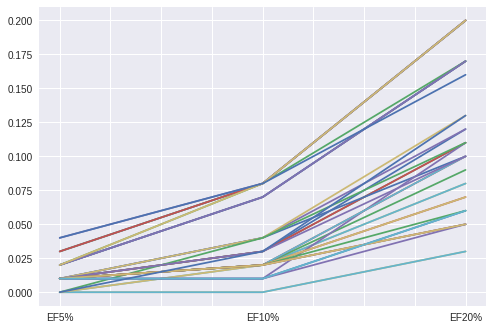

In [38]:
performances_df[["EF5%", "EF10%", "EF20%"]].transpose().plot(legend=False)

In [39]:
performances_df[["EF5%", "EF10%", "EF20%"]].mean()

EF5%     0.013243
EF10%    0.038108
EF20%    0.112973
dtype: float64

In [40]:
enrichment_data = pd.DataFrame(enrichment_data_list, columns=["ligand", "kinase", "data"]).explode("data")
enrichment_data["x"] = enrichment_data["data"].apply(lambda x: x[1])
enrichment_data["y"] = enrichment_data["data"].apply(lambda x: x[0])
enrichment_data = enrichment_data.drop("data", axis=1)
enrichment_data

,ligand,kinase,x,y
0,Dasatinib,ABL1,0.000000,0.00000
0,Dasatinib,ABL1,0.005348,0.03125
0,Dasatinib,ABL1,0.016043,0.06250
0,Dasatinib,ABL1,0.026738,0.09375
0,Dasatinib,ABL1,0.037433,0.12500
...,...,...,...,...
36,Erlotinib,EGFR,0.957219,1.00000
36,Erlotinib,EGFR,0.967914,1.00000
36,Erlotinib,EGFR,0.978610,1.00000
36,Erlotinib,EGFR,0.989305,1.00000


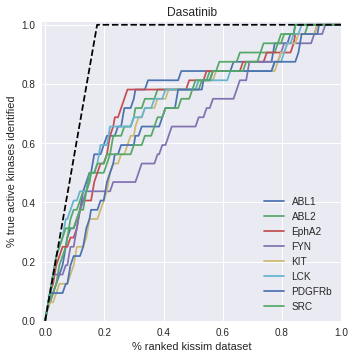

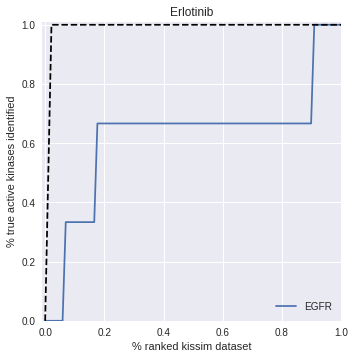

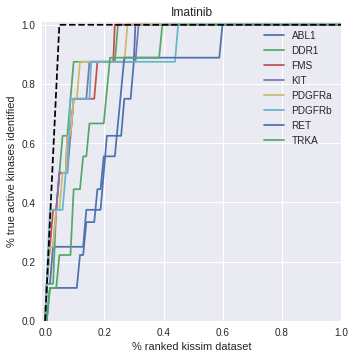

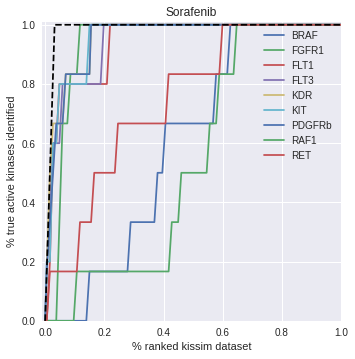

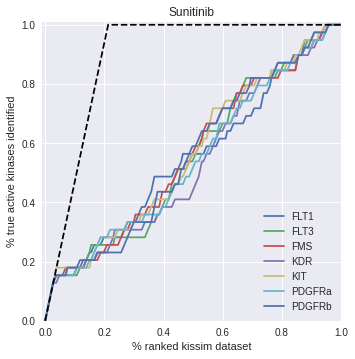

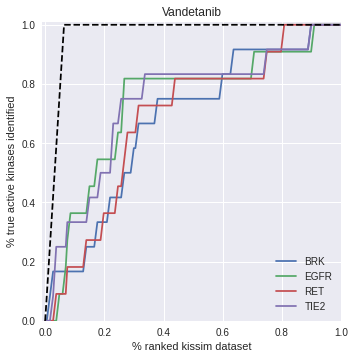

In [41]:
data = {}
for ligand_name, data1 in enrichment_data.groupby("ligand"):
    data[ligand_name] = []
    for kinase_name, data2 in data1.groupby("kinase"):
        data_tmp = data2.set_index("x")["y"]
        data_tmp.name = kinase_name
        data[ligand_name].append(data_tmp)
    data[ligand_name] = pd.concat(data[ligand_name], axis=1)

for ligand_name, df in data.items():
    # Experimental curves
    ax = data[ligand_name].plot(title=ligand_name, ylim=(0, 1.01), xlim=(-0.01, 1))
    # Optimal curve for ligand
    ligand_dataset = create_ligand_dataset(karaman_df, kissim_df, ligand_name, kinase_name, KD_CUTOFF)
    ax.plot([0, enrichment_optimal(ligand_dataset), 1], [0, 1, 1], "--", color="k")
    # Cosmetics
    ax.set_xlabel("% ranked kissim dataset")
    ax.set_ylabel("% true active kinases identified")
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")

## Appendix